In [1]:
%cd ~/mechanistic-unlearning
%load_ext autoreload
%autoreload 2
import functools
import os
import gc
import json
# from tkinter import font
import sys

from dataset.custom_dataset import PairedInstructionDataset
import torch

from transformer_lens import HookedTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import numpy as np
from tqdm.auto import tqdm
from datasets import load_dataset
import einops
from transformer_lens import ActivationCache
import time

# project_root = os.path.abspath(os.path.dirname(__file__))
project_root = "/data/phillip_guo/mechanistic-unlearning"

# Add the project root and its subdirectories to the Python path
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'masks_learning'))
sys.path.insert(0, os.path.join(project_root, 'localizations'))
sys.path.insert(0, os.path.join(project_root, 'tasks'))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/mechanistic-unlearning


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "google/gemma-7b"
model_type = "gemma_7b"
model = HookedTransformer.from_pretrained(
    model_name,
    device='cuda',
    default_padding_side="left",
    fold_ln=False,
    fold_value_biases=False,
    center_writing_weights=False,
    dtype=torch.bfloat16
)
tokenizer = model.tokenizer

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.
Loading checkpoint shards: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]


Loaded pretrained model google/gemma-7b into HookedTransformer


## Develop CounterFact Dataset

In [3]:
import pandas as pd

counterfact_df = load_dataset("PhillipGuo/counterfact-with-gemma-probs", split=model_type).to_pandas()
correct_prob_threshold = 0.5
# filter for when model gets first token correct (assuming future tokens will also be correct)
counterfact_df = counterfact_df[counterfact_df["prob_of_correct_answer"] >= correct_prob_threshold]

In [4]:
def get_token_sequence_pos(prompt_list, token_strs, batch_size=64):
    
    substring_start_positions = []
    substring_end_positions = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        
        tokenized_substrings = tokenizer(token_strs[i:i+batch_size]).input_ids
        for j in range(len(tokenized_substrings)):
            if tokenized_substrings[j][0] == tokenizer.bos_token_id:
                substring = tokenized_substrings[j][1:]
            else:
                substring = tokenized_substrings[j]
            substring = torch.tensor(substring)
            prompt = tokenized_prompts.input_ids[j]
            # print(prompt, substring)

            # Find the last occurrence of the substring
            for k in range(len(prompt) - len(substring), -1, -1):
                if torch.all(prompt[k:k+len(substring)] == substring):
                    substring_start_positions.append(k - len(prompt))
                    substring_end_positions.append(k + len(substring) - len(prompt))
                    # if 0, then we are at the end of the prompt, we should treat it weird after
                    # if k - len(prompt) < 0:
                    #     substring_start_positions.append(k - len(prompt))
                    # else:
                    #     substring_start_positions.append(len(prompt))
                    # if k+len(substring) < len(prompt):
                    #     substring_end_positions.append((k+len(substring))-len(prompt))
                    # else:
                    #     substring_end_positions.append(len(prompt))
                    break
            else:
                # If substring not found, append 1
                substring_start_positions.append(1)
                substring_end_positions.append(1)
    return substring_start_positions, substring_end_positions

substring_start_positions, substring_end_positions = get_token_sequence_pos((counterfact_df["prompt"] + counterfact_df["target_true"]).tolist(), counterfact_df["target_true"].tolist())
# # model process full prompt

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:00<00:00, 330.82it/s]


In [5]:
# # model process full prompt
# batch_size = 64
# prompt_list = (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()
# tokenized_substrings = tokenizer(counterfact_df["target_true"].tolist()).input_ids

# correct_probs = []
# for i in tqdm(range(0, len(prompt_list), batch_size)):
#     tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
#     prompt_toks = tokenized.input_ids
#     attn_mask = tokenized.attention_mask
#     current_substring_positions = substring_positions[i:i+batch_size]

#     with torch.set_grad_enabled(False):
#         output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())
    
#     for j in range(len(current_substring_positions)):
#         # check [pos-1: -1]
#         answer_preds = output[j, current_substring_positions[j]-1: -1]

#         if tokenized_substrings[i+j][0] == tokenizer.bos_token_id:
#             label = tokenized_substrings[i+j][1:]
#         else:
#             label = tokenized_substrings[i+j]
#         label = torch.tensor(label)
        
#         # get probability of correct answer across all label tokens (answer_preds is answer_len x vocab, label is shape (answer_len,))
#         probs = torch.nn.functional.softmax(answer_preds, dim=-1)
#         correct_prob = probs[torch.arange(len(label)), label]
#         # multiply across answer_len
#         correct_probs.append(torch.prod(correct_prob).item())
    
# print(torch.tensor(correct_probs).mean())
# import matplotlib.pyplot as plt
# plt.hist(correct_probs)
# plt.show()

## Cache Activations

In [6]:
# get activations at these positions
from collections import defaultdict
def retrieve_acts(model, prompt_list, batch_size, layer=None, to_cpu=False, truncate_length=None, sequence_pos=None):
    if layer is None:
        caches = defaultdict(list)
    else:
        caches = []
    if isinstance(sequence_pos, int):
        sequence_pos = torch.tensor([sequence_pos] * len(prompt_list))
    elif sequence_pos is None:
        sequence_pos = torch.tensor([-1] * len(prompt_list))
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized_prompts = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        if truncate_length is not None:
            if len(prompt_toks[0]) > truncate_length:
                print(f"Prompt {i} is too long, truncating")
                prompt_toks = prompt_toks[:, -truncate_length:]
                attn_mask = attn_mask[:, -truncate_length:]

        _, cache = model.run_with_cache(
            prompt_toks,
            attention_mask=attn_mask,
            names_filter = (lambda name: f"hook_resid_post" in name) if layer is None else (f"blocks.{layer}.hook_resid_post")
        )
        batch_sequence_pos_index = sequence_pos[i:i+batch_size]

        if layer is None:
            for k, v in cache.items():
                key_layer = int(k.split(".")[1])

                if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                    batch_index = torch.arange(v.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
                else:
                    batch_index = torch.arange(v.shape[0])
                sequence_cache = v[batch_index, batch_sequence_pos_index, :]
                if to_cpu:
                    sequence_cache = sequence_cache.cpu()
                caches[key_layer].append(sequence_cache)
        else:
            if isinstance(sequence_pos, torch.Tensor) and len(sequence_pos.shape) > 1:
                batch_index = torch.arange(cache.shape[0]).unsqueeze(-1).repeat(1, batch_sequence_pos_index.shape[1])
            else:
                batch_index = torch.arange(cache.shape[0])
            sequence_cache = cache[f"blocks.{layer}.hook_resid_post"][batch_index, batch_sequence_pos_index, :]
            caches.append(sequence_cache.cpu() if to_cpu else sequence_cache)
    if layer is None:
        for k, v in caches.items():
            caches[k] = torch.cat(v, dim=0)
    else:
        caches = torch.cat(caches, dim=0)
    return caches


In [7]:
import pickle
load_acts = True
if load_acts:
    with open(f"experiments/gemma_7b_manual/counterfact_true_false_acts_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        true_acts = data["true_acts"]
        false_acts = data["false_acts"]
else:
    true_acts = retrieve_acts(model, [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()], batch_size=32, sequence_pos=-1, to_cpu=True)
    false_acts = retrieve_acts(model, [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()], batch_size=32, sequence_pos=-1, to_cpu=True)
    true_acts = {layer: true_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    false_acts = {layer: false_acts[layer].cpu().float().numpy() for layer in range(model.cfg.n_layers)}
    with open(f"experiments/gemma_7b_manual/counterfact_true_false_acts_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"true_acts": true_acts, "false_acts": false_acts}, f)


In [8]:
for layer in range(model.cfg.n_layers):
    print(true_acts[layer].shape)
    print(false_acts[layer].shape)
    print(true_acts[layer].mean())
    print(false_acts[layer].mean())

(2169, 3072)
(2169, 3072)
-0.0025819433
-0.0025826246
(2169, 3072)
(2169, 3072)
-0.0011457064
-0.0011461582
(2169, 3072)
(2169, 3072)
0.0011484821
0.0011305264
(2169, 3072)
(2169, 3072)
0.00060208334
0.0005842908
(2169, 3072)
(2169, 3072)
-0.0014300587
-0.0014429024
(2169, 3072)
(2169, 3072)
5.134535e-05
6.540376e-06
(2169, 3072)
(2169, 3072)
-0.00023541748
-0.00024821007
(2169, 3072)
(2169, 3072)
-0.00029444986
-0.00030166094
(2169, 3072)
(2169, 3072)
-0.00076410454
-0.00074527645
(2169, 3072)
(2169, 3072)
-0.0014443728
-0.0014505908
(2169, 3072)
(2169, 3072)
-0.00012027039
-0.00010959621
(2169, 3072)
(2169, 3072)
0.00076561054
0.00071120413
(2169, 3072)
(2169, 3072)
-0.0009427543
-0.0009778517
(2169, 3072)
(2169, 3072)
-0.0005797604
-0.000627281
(2169, 3072)
(2169, 3072)
0.00020480214
0.00015890505
(2169, 3072)
(2169, 3072)
0.00055026566
0.0005614716
(2169, 3072)
(2169, 3072)
-0.0006476216
-0.00073130464
(2169, 3072)
(2169, 3072)
-0.00026467064
-0.00023401255
(2169, 3072)
(2169, 3072

## Train Probes

In [9]:
from sklearn.preprocessing import StandardScaler
from multiprocessing.dummy import Pool as ThreadPool
def train_test_probe(X_train, X_test, y_train, y_test, preprocess=True, return_scaler=False):
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LogisticRegression(solver='sag', max_iter=500).fit(X_train, y_train)
    if return_scaler:
        return clf.score(X_test, y_test), clf, scaler
    return clf.score(X_test, y_test), clf

results_dict = {}
def get_shuffle_indices(length):
    np.random.seed(42)  # Set a constant seed
    return np.random.permutation(length)

shuffle_indices = get_shuffle_indices(len(counterfact_df["target_true"]) + len(counterfact_df["target_false"])) # should look like array([3975, 1448, 2662, ..., 3092, 3772,  860])
print(shuffle_indices)
split_index = int(0.8 * len(shuffle_indices))

train_indices = shuffle_indices[:split_index]
test_indices = shuffle_indices[split_index:]

def format_data(layer):
    total_acts = np.concatenate([true_acts[layer], false_acts[layer]], axis=0)
    total_labels = np.concatenate([np.ones(true_acts[layer].shape[0]), np.zeros(false_acts[layer].shape[0])], axis=0)
    # shuffle and split
    # total_acts = total_acts[shuffle_indices]
    # total_labels = total_labels[shuffle_indices]
    X_train = total_acts[train_indices]
    X_test = total_acts[test_indices]
    y_train = total_labels[train_indices]
    y_test = total_labels[test_indices]
    return X_train, X_test, y_train, y_test

def probe_layer(layer):
    X_train, X_test, y_train, y_test = format_data(layer)
    return train_test_probe(X_train, X_test, y_train, y_test)


load_probes = True
if load_probes:
    with open(f"experiments/gemma_7b_manual/counterfact_clfs_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        clfs = data["clfs"]
        results_dict = data["results_dict"]
        scalers = data["scalers"]
else:
    clfs = {}
    scalers = {}
    for layer in tqdm(range(model.cfg.n_layers)):
        total_acts = np.concatenate([true_acts[layer], false_acts[layer]], axis=0)
        total_labels = np.concatenate([np.ones(true_acts[layer].shape[0]), np.zeros(false_acts[layer].shape[0])], axis=0)
        # shuffle and split
        total_acts = total_acts[shuffle_indices]
        total_labels = total_labels[shuffle_indices]
        split_index = int(0.8 * total_acts.shape[0])
        X_train = total_acts[:split_index]
        X_test = total_acts[split_index:]
        y_train = total_labels[:split_index]
        y_test = total_labels[split_index:]
        test_acc, clf, scaler = train_test_probe(X_train, X_test, y_train, y_test, return_scaler=True)
        results_dict[layer] = test_acc
        clfs[layer] = clf
        scalers[layer] = scaler
    print(results_dict)

    with open(f"experiments/gemma_7b_manual/counterfact_clfs_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"clfs": clfs, "results_dict": results_dict, "scalers": scalers}, f)
# print("Starting multiprocessing")
# start_time = time.time()
# with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
#     results = pool.starmap(probe_layer, [(layer,) for layer in range(model.cfg.n_layers)])
# end_time = time.time()
# print(f"Time taken: {end_time - start_time} seconds")
# print(results)

[ 175  478 2533 ... 3092 3772  860]


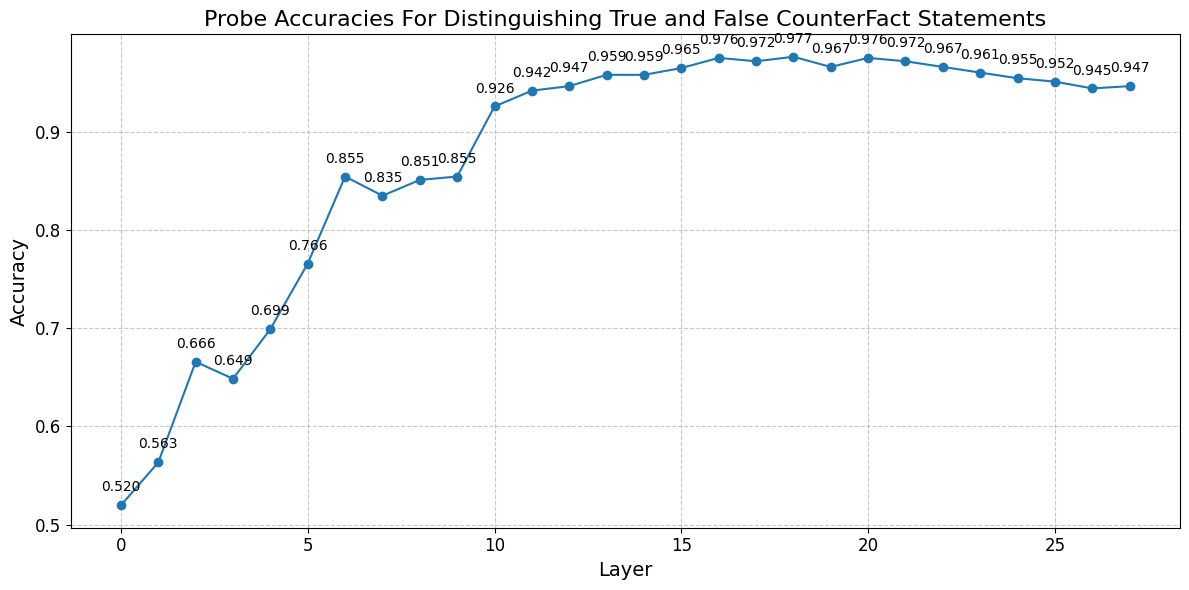

In [10]:
import matplotlib.pyplot as plt

# results_dict = {0: 0.5231523722627737, 1: 0.5882755474452555, 2: 0.6528284671532847, 3: 0.6526003649635036, 4: 0.6905793795620438, 5: 0.7166970802919708, 6: 0.7844434306569343, 7: 0.7874087591240876, 8: 0.7831888686131386, 9: 0.7979014598540146, 10: 0.8561815693430657, 11: 0.8616560218978102, 12: 0.8640510948905109, 13: 0.8622262773722628, 14: 0.8641651459854015, 15: 0.864507299270073, 16: 0.8638229927007299, 17: 0.8669023722627737, 18: 0.8657618613138686, 19: 0.8664461678832117, 20: 0.864507299270073, 21: 0.8654197080291971, 22: 0.864279197080292, 23: 0.8598312043795621, 24: 0.8560675182481752, 25: 0.8540145985401459, 26: 0.8447764598540146, 27: 0.84375}
# Extract layers and accuracies from the results_dict
layers = list(results_dict.keys())
accuracies = list(results_dict.values())

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(layers, accuracies, marker='o')

# Customize the plot
plt.title('Probe Accuracies For Distinguishing True and False CounterFact Statements', fontsize=16)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on the points
for i, accuracy in enumerate(accuracies):
    plt.annotate(f'{accuracy:.3f}', (layers[i], accuracy), textcoords="offset points", xytext=(0,10), ha='center')

# Show the plot
plt.tight_layout()
plt.show()

### Try one probe per question type

In [36]:
pd.set_option('display.max_rows', 300)
counterfact_df["target_true"].value_counts().head(5)

target_true
French       301
Microsoft    138
Apple         94
English       77
Google        69
Name: count, dtype: int64

In [35]:
target_classifications = {
    "Countries/Continents": [
        'India', 'Germany', 'Norway', 'Pakistan', 'Denmark', 'Iran', 'Japan', 
        'Canada', 'Venezuela', 'Greece', 'Switzerland', 'Qatar', 'Brazil', 
        'Mexico', 'Italy', 'Austria', 'Russia', 'Argentina', 'Turkey', 'Slovakia', 
        'Chile', 'Australia', 'Poland', 'Ukraine', 'Iceland', 'Bulgaria', 'England', 
        'Scotland', 'Croatia', 'Bangladesh', 'Malaysia', 'Libya', 'Egypt', 'Cuba', 
        'South Korea', 'Colombia', 'Israel', 'Thailand', 'Lebanon', 'Afghanistan', 
        'Rwanda', 'Oman', 'Iraq', 'Liberia', 'Nepal', 'Kenya', 'Armenia', 'Ghana', 
        'Portugal', 'Belarus', 'Malta', 'Netherlands', 'Nigeria', 'Fiji', 'Antarctica', 
        'Europe', 'Africa', 'Asia', 'Morocco', 'Sweden', 'Latvia', 'Estonia', 'Luxembourg', 
        'Belgium', 'Peru', 'Bolivia', 'Indonesia', 'Czech', 'Romania', 'Finland'
    ],
    "Languages/Nationalities": [
        'French', 'Dutch', 'Icelandic', 'Greek', 'Tamil', 'Persian', 'Italian', 
        'Russian', 'Catalan', 'Spanish', 'English', 'Finnish', 'Romanian', 'German', 
        'Swedish', 'Portuguese', 'Hebrew', 'Latin', 'Chinese', 'Serbian', 'Armenian', 
        'Japanese', 'Korean', 'Croatian', 'Bulgarian', 'Polish', 'Norwegian', 'Danish', 
        'Turkish', 'Hungarian', 'Ukrainian'
    ],
    "Cities": [
        'Philadelphia', 'Boston', 'Princeton', 'Mumbai', 'Beijing', 'Chennai', 'Kabul', 
        'Bangalore', 'Helsinki', 'Toronto', 'Montreal', 'Ottawa', 'Detroit', 'Rome', 
        'Florence', 'Jakarta', 'Windsor', 'Geneva', 'Kyoto', 'Paris', 'Tehran', 'Berlin', 
        'Vienna', 'Stockholm', 'Houston', 'Tripoli', 'Chicago', 'Oslo', 'Nashville', 
        'Seattle', 'Atlanta', 'Austin', 'Naples', 'Milan', 'Reno', 'Alexandria', 
        'Singapore', 'Baghdad', 'Athens', 'Columbia', 'Beirut', 'Cairo', 'Frankfurt', 
        'Hamburg', 'Santiago', 'Jerusalem', 'Pasadena', 'Miami', 'Milwaukee', 'Tampa', 
        'Dallas', 'Edmonton', 'Melbourne', 'Cologne', 'Monroe', 'Tokyo', 'Prague', 
        'Winnipeg', 'Karachi', 'Honolulu', 'Cincinnati', 'Canberra', 'Warsaw', 
        'Lisbon', 'Madrid', 'Glasgow', 'Dublin', 'Seoul', 'Belfast', 'Munich', 'Cambridge', 
        'Lexington', 'Providence', 'Venice', 'Quincy', 'Amsterdam', 'Vancouver', 'Durham', 
        'Edinburgh', 'Stamford', 'Lancaster', 'Leeds', 'Baltimore', 'Tours', 'Birmingham', 
        'Tacoma', 'Rochester', 'Manchester', 'Springfield', 'Norfolk', 'Surrey', 'Pasadena', 
        'Hamilton', 'Vernon', 'Douglas', 'Gary', 'Franklin'
    ],
    "Companies/Brands/Media": [
        'Apple', 'Toyota', 'Microsoft', 'Honda', 'Samsung', 'Google', 'Nintendo', 
        'IBM', 'Nokia', 'Ferrari', 'Intel', 'Adobe', 'Amazon', 'Airbus', 'Boeing', 
        'Volvo', 'Suzuki', 'Porsche', 'Chrysler', 'Bentley', 'Renault', 'Atari', 
        'Sega', 'Sony', 'BMW', 'Dodge', 'Nissan', 'Yahoo', 'Netflix', 'Square', 'Yamaha', 
        'CBS', 'HBO', 'PBS', 'ESPN', 'MTV', 'NBC', 'Lifetime', 'ITV', 'CNN', 'Bravo', 
        'BBC', 'Sky', 'WWE', 'Avengers'
    ],
    "Occupations": [
        'catcher', 'quarterback', 'football', 'soccer', 'basketball', 'baseball', 
        'actor', 'politician'
    ],
    "Miscellaneous": [
        'Scientology', 'Islam', 'Buddhism', 'Judaism', 'Python', 'Hamas', 'Fowler', 
        'Leonardo', 'Franklin', 'Douglas', 'Vernon', 'Hamilton', 'Monroe', "piano", "violin"
    ]
}

reverse_classifications = {f" {v_item}": k for k, v in target_classifications.items() for v_item in v}

def get_classification(row):
    if row["target_true"] in reverse_classifications:
        return reverse_classifications[row["target_true"]]
    else:
        return "Miscellaneous"

counterfact_df["answer_classification"] = counterfact_df.apply(get_classification, axis=1)
counterfact_df["answer_classification"].value_counts()


answer_classification
Languages/Nationalities    690
Companies/Brands/Media     635
Countries/Continents       370
Cities                     262
Miscellaneous              175
Occupations                 37
Name: count, dtype: int64

In [50]:
# redo probing, one set of probing per answer_classification type
from sklearn.preprocessing import StandardScaler
from multiprocessing.dummy import Pool as ThreadPool
def train_test_probe(X_train, X_test, y_train, y_test, preprocess=True, return_scaler=False):
    if preprocess:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    clf = LogisticRegression(solver='sag').fit(X_train, y_train)
    if return_scaler:
        return clf.score(X_test, y_test), clf, scaler
    return clf.score(X_test, y_test), clf

results_dict = {}
def get_shuffle_indices(length):
    np.random.seed(42)  # Set a constant seed
    return np.random.permutation(length)


load_probes = False
if load_probes:
    with open(f"experiments/gemma_7b_manual/counterfact_clfs_class_split.pkl", "rb") as f:
        data = pickle.load(f)
        clfs = data["clfs"]
        results_dict = data["results_dict"]
        scalers = data["scalers"]
else:
    all_class_clfs = {}
    all_class_scalers = {}
    all_shuffle_indices = {}
    all_results_dict = {}
    for class_type in tqdm(counterfact_df["answer_classification"].unique()):
        all_class_clfs[class_type] = {}
        all_class_scalers[class_type] = {}
        all_results_dict[class_type] = {}
        class_indices = counterfact_df.reset_index()["answer_classification"] == class_type

        shuffle_indices = get_shuffle_indices(class_indices.sum()) # should look like array([3975, 1448, 2662, ..., 3092, 3772,  860])
        print("For Class Type", class_type, "there are", class_indices.sum(), "examples")
        all_shuffle_indices[class_type] = shuffle_indices
        split_index = int(0.8 * len(shuffle_indices))
        train_indices = shuffle_indices[:split_index]
        test_indices = shuffle_indices[split_index:]

        for layer in tqdm(range(model.cfg.n_layers)):
            true_class_acts = true_acts[layer][class_indices]
            false_class_acts = false_acts[layer][class_indices]
            # total_acts = np.concatenate([true_acts[layer][class_indices], false_acts[layer][class_indices]], axis=0)
            # total_labels = np.concatenate([np.ones(true_acts[layer][class_indices].shape[0]), np.zeros(false_acts[layer][class_indices].shape[0])], axis=0)
            # shuffle and split
            X_train = np.concatenate([true_class_acts[train_indices], false_class_acts[train_indices]], axis=0)
            X_test = np.concatenate([true_class_acts[test_indices], false_class_acts[test_indices]], axis=0)
            y_train = np.concatenate([np.ones(len(train_indices)), np.zeros(len(train_indices))], axis=0)
            y_test = np.concatenate([np.ones(len(test_indices)), np.zeros(len(test_indices))], axis=0)
            test_acc, clf, scaler = train_test_probe(X_train, X_test, y_train, y_test, return_scaler=True)

            all_results_dict[class_type][layer] = test_acc
            all_class_clfs[class_type][layer] = clf
            all_class_scalers[class_type][layer] = scaler
        print(results_dict)

with open(f"experiments/gemma_7b_manual/counterfact_clfs_class_split.pkl", "wb") as f:
    pickle.dump({"clfs": all_class_clfs, "results_dict": all_results_dict, "scalers": all_class_scalers}, f)
# start_time = time.time()
# with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
#     results = pool.starmap(probe_layer, [(layer,) for layer in range(model.cfg.n_layers)])
# end_time = time.time()
# print(f"Time taken: {end_time - start_time} seconds")
# print(results)

  0%|          | 0/6 [00:00<?, ?it/s]

For Class Type Languages/Nationalities there are 690 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}
For Class Type Companies/Brands/Media there are 635 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}
For Class Type Cities there are 262 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}
For Class Type Countries/Continents there are 370 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}
For Class Type Occupations there are 37 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}
For Class Type Miscellaneous there are 175 examples


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{}


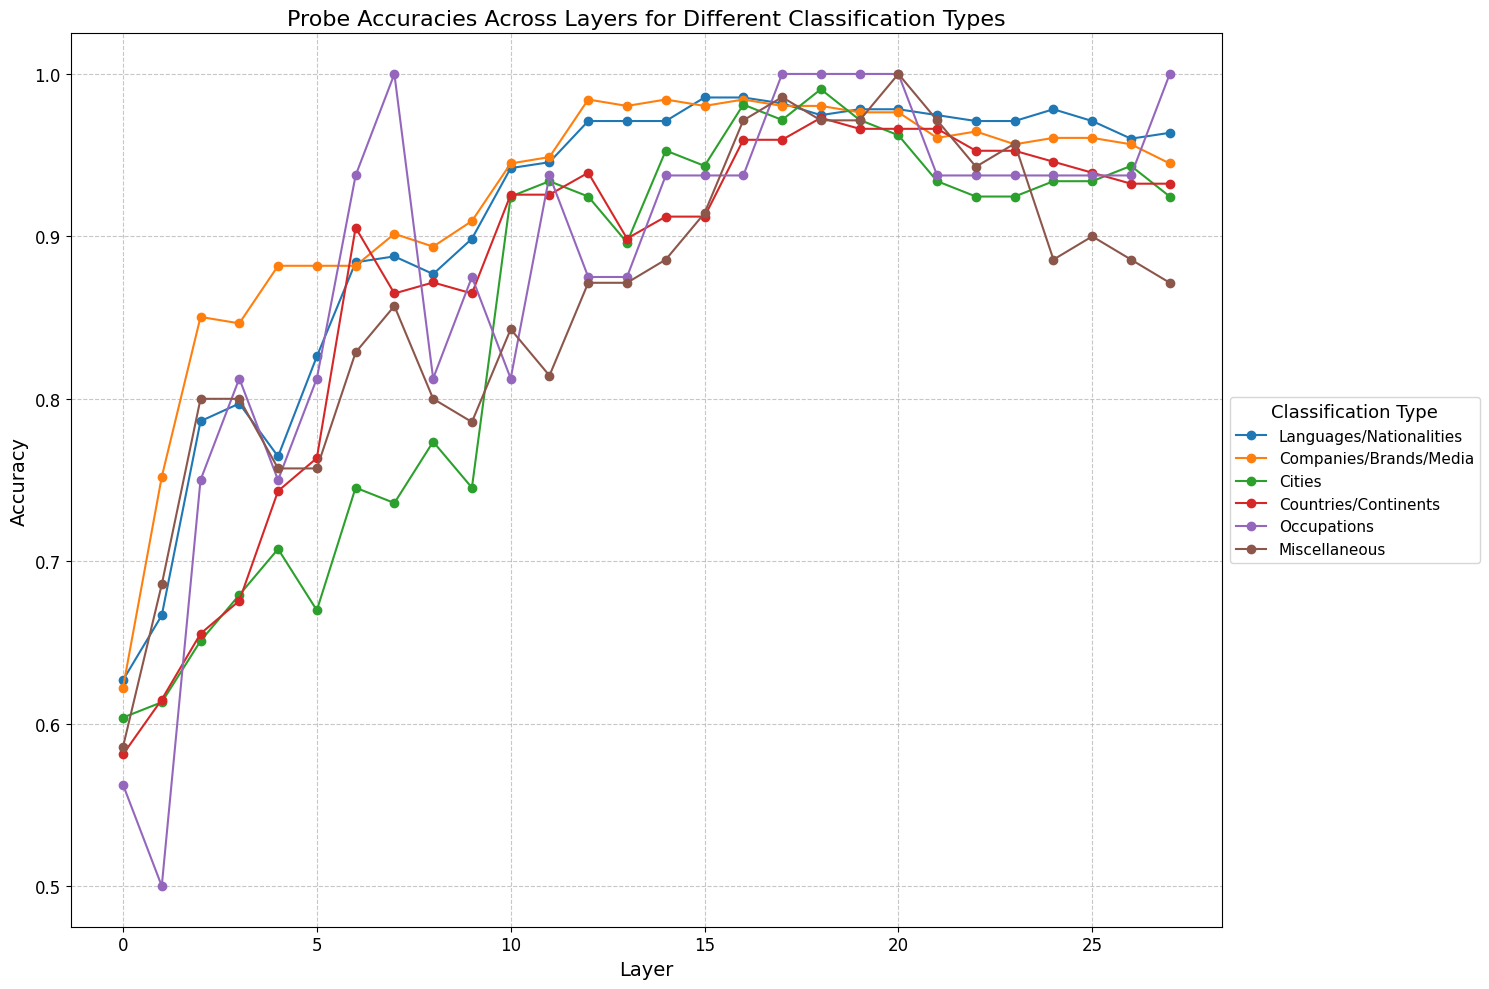

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming all_results_dict is already loaded and contains the accuracies

# Create a new figure
plt.figure(figsize=(15, 10))

# Plot a line for each classification type
for class_type, accuracies in all_results_dict.items():
    layers = list(accuracies.keys())
    acc_values = list(accuracies.values())
    plt.plot(layers, acc_values, label=class_type, marker='o')

# Customize the plot
plt.title('Probe Accuracies Across Layers for Different Classification Types', fontsize=16)
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(title='Classification Type', title_fontsize='13', fontsize='11', loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True, linestyle='--', alpha=0.7)

# Improve readability
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

## Perform Ablations

### Patch Corrupt into Clean

In [55]:
import einops
# get mean ablation cache
load_mean_cache = True

if load_mean_cache:
    with open(f"experiments/gemma_7b_manual/counterfact_mean_caches_{correct_prob_threshold=}.pkl", "rb") as f:
        data = pickle.load(f)
        attn_cache = data["attn_cache"]
        mlp_cache = data["mlp_cache"]
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = attn_cache[layer].cuda()
        mlp_cache[layer] = mlp_cache[layer].cuda()

else:
    attn_cache = {}
    mlp_cache = {}
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = torch.zeros((16, model.cfg.d_head)).to("cuda")
        mlp_cache[layer] = torch.zeros((model.cfg.d_model)).to("cuda")

    batch_size = 16
    all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
    with torch.set_grad_enabled(False):
        for i in tqdm(range(0, len(all_prompts), batch_size)):
            tokenized_prompts = tokenizer(all_prompts[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
            prompt_toks = tokenized_prompts.input_ids
            attn_mask = tokenized_prompts.attention_mask

            _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: 'hook_z' in name or 'mlp_out' in name)
            for layer in range(model.cfg.n_layers):
                attn_cache[layer] += einops.reduce(cache[f'blocks.{layer}.attn.hook_z'], "batch seq head d_head -> head d_head", "mean")
                mlp_cache[layer] += einops.reduce(cache[f'blocks.{layer}.hook_mlp_out'], "batch seq d_mlp -> d_mlp", "mean")

    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = (attn_cache[layer] / (len(all_prompts) // batch_size)).cpu()
        mlp_cache[layer] = (mlp_cache[layer] / (len(all_prompts) // batch_size)).cpu()
    
    with open(f"experiments/gemma_7b_manual/counterfact_mean_caches_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"attn_cache": attn_cache, "mlp_cache": mlp_cache}, f)
    for layer in range(model.cfg.n_layers):
        attn_cache[layer] = attn_cache[layer].cuda()
        mlp_cache[layer] = mlp_cache[layer].cuda()

In [56]:
all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]
start_subject_pos, end_subject_pos = get_token_sequence_pos(all_prompts, subject_list)
subject_ranges = list(zip(start_subject_pos, end_subject_pos))
tokenized = tokenizer(all_prompts[:16], return_tensors="pt", padding=True)
for i in range(16):
    input_ids = tokenized.input_ids[i]
    print(tokenizer.decode(input_ids[subject_ranges[i][0]:subject_ranges[i][1]]))

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 114.06it/s]

 Danielle Darrieux
 Thomas Joannes Stieltjes
Apple A5
 The Icelandic Dream
 Monell Chemical Senses Center
 Jean Galland
Tapio Kantanen
Toyota Cresta
Windows Embedded CE 6.0
Nathuram Godse
Stefanos Stratigos
Hohenlohe-Langenburg
 Thoranai
Honda Insight
 Northeastern University
 Cees Nooteboom


In [61]:
# Try ablating every head
# get results of probes for 
default_labels = np.concatenate([np.ones(len(counterfact_df["target_true"])), np.zeros(len(counterfact_df["target_false"]))], axis=0)
def evaluate_cache(caches, test_indices=test_indices, labels=default_labels, preprocess=True, probes=clfs, scalers=scalers):
    correct_responses = {}
    accuracies = {}
    for layer in range(model.cfg.n_layers):
        X_test = caches[layer][test_indices]
        if preprocess:
            X_test = scalers[layer].transform(X_test)
        y_test = labels[test_indices]

        clf = probes[layer]
        accuracies[layer] = clf.score(X_test, y_test)
        # get list of 0s and 1s for each element in test, 0 if probe is wrong and 1 if probe is right
        probe_results = clf.predict(X_test)
        correct_responses[layer] = (probe_results == y_test).astype(int)
    return correct_responses, accuracies

def mean_ablate_subject(prompt_list, subject_list, layers, head=None, head_dict=None, attn=False, mlp=False, batch_size=32):
    start_subject_pos, end_subject_pos = get_token_sequence_pos(prompt_list, subject_list)
    subject_ranges = list(zip(start_subject_pos, end_subject_pos))

    """
    Mean ablate subject of prompt for particular layer. Then, run probes and see which prompts the probes get wrong.
    prompt_list and subject_list should be same length
    """
    if isinstance(layers, int):
        layers = [layers]
    if isinstance(head, int):
        head = [head]

    if head is not None and head_dict is None:
        head_dict = {layer: head for layer in layers}

    caches = defaultdict(list)
    if attn:
        def mean_ablate_hook(input, hook, layer, head, ablation_ranges):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            # input is batch seq heads d_head
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:, head] = attn_cache[layer][head]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head] = attn_cache[layer][head]
            return input
    elif mlp:
        def mean_ablate_hook(input, hook, layer, ablation_ranges):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:] = mlp_cache[layer]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] = mlp_cache[layer]
            return input
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        prompt_toks = tokenized.input_ids
        attn_mask = tokenized.attention_mask
        hooks = []
        if attn:
            for layer, heads in head_dict.items():
                for head in heads:
                    hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: mean_ablate_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size])))
        elif mlp:
            for layer in layers:
                hooks.append((f"blocks.{layer}.hook_mlp_out", lambda input, hook: mean_ablate_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size])))
        with torch.set_grad_enabled(False):
            with model.hooks(hooks):
                _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: 'resid_post' in name)

        for layer in range(model.cfg.n_layers):
            caches[layer].append(cache[f"blocks.{layer}.hook_resid_post"][:, -1, :])
    print("Concatenating caches")
    for layer in range(model.cfg.n_layers):
        caches[layer] = torch.cat(caches[layer], dim=0).cpu().float().numpy()
    # return caches
    return *evaluate_cache(caches, probes=clfs, scalers=scalers), caches

all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]

correct_responses, accuracies, caches = mean_ablate_subject(all_prompts, subject_list, layers=27, attn=True, head=15)

  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 136/136 [00:19<00:00,  7.07it/s]


Concatenating caches


In [91]:
attn_correct_responses = defaultdict(dict)
attn_accuracies = defaultdict(dict)
mlp_correct_responses = {}
mlp_accuracies = {}
for layer in tqdm(range(model.cfg.n_layers)):
    print("Layer: ")
    for head in range(model.cfg.n_heads):
        correct_responses, accuracies, _ = mean_ablate_subject(all_prompts, subject_list, attn=True, layers=layer, head=head)
        attn_correct_responses[layer][head] = correct_responses
        attn_accuracies[layer][head] = accuracies
    correct_responses, accuracies, _ = mean_ablate_subject(all_prompts, subject_list, mlp=True, layers=layer)
    mlp_correct_responses[layer] = correct_responses
    mlp_accuracies[layer] = accuracies

    with open(f"experiments/gemma_7b_manual/counterfact_ablation_results_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"attn_correct_responses": attn_correct_responses, "attn_accuracies": attn_accuracies, "mlp_correct_responses": mlp_correct_responses, "mlp_accuracies": mlp_accuracies}, f)

  0%|          | 0/28 [00:00<?, ?it/s]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.08it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.06it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.04it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.03it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


  4%|▎         | 1/28 [06:33<2:57:17, 393.97s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


  7%|▋         | 2/28 [13:12<2:51:47, 396.43s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


 11%|█         | 3/28 [19:53<2:46:10, 398.82s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.93it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


 14%|█▍        | 4/28 [26:35<2:40:01, 400.08s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 18%|█▊        | 5/28 [33:17<2:33:37, 400.78s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


 21%|██▏       | 6/28 [39:59<2:27:04, 401.12s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.92it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 25%|██▌       | 7/28 [46:41<2:20:29, 401.42s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.93it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


 29%|██▊       | 8/28 [53:22<2:13:46, 401.34s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 32%|███▏      | 9/28 [1:00:04<2:07:08, 401.52s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 36%|███▌      | 10/28 [1:06:46<2:00:27, 401.52s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 39%|███▉      | 11/28 [1:13:21<1:53:12, 399.53s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.93it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


 43%|████▎     | 12/28 [1:19:58<1:46:23, 398.94s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 46%|████▋     | 13/28 [1:26:29<1:39:05, 396.36s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 50%|█████     | 14/28 [1:32:57<1:31:52, 393.77s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 54%|█████▎    | 15/28 [1:39:27<1:25:06, 392.79s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 57%|█████▋    | 16/28 [1:45:57<1:18:24, 392.07s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.92it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 61%|██████    | 17/28 [1:52:27<1:11:42, 391.18s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 64%|██████▍   | 18/28 [1:58:57<1:05:08, 390.85s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 68%|██████▊   | 19/28 [2:05:30<58:44, 391.60s/it]  

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 71%|███████▏  | 20/28 [2:12:02<52:14, 391.78s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 75%|███████▌  | 21/28 [2:18:34<45:43, 391.86s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.96it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 79%|███████▊  | 22/28 [2:25:01<39:01, 390.31s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 82%|████████▏ | 23/28 [2:31:31<32:31, 390.24s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 86%|████████▌ | 24/28 [2:38:04<26:04, 391.05s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


 89%|████████▉ | 25/28 [2:44:34<19:32, 390.75s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.94it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 93%|█████████▎| 26/28 [2:51:10<13:04, 392.29s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


 96%|█████████▋| 27/28 [2:57:38<06:31, 391.16s/it]

Layer: 


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.92it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  6.95it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.00it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.01it/s]


Concatenating caches


100%|██████████| 136/136 [00:19<00:00,  7.02it/s]


Concatenating caches


100%|██████████| 28/28 [3:04:17<00:00, 394.89s/it]


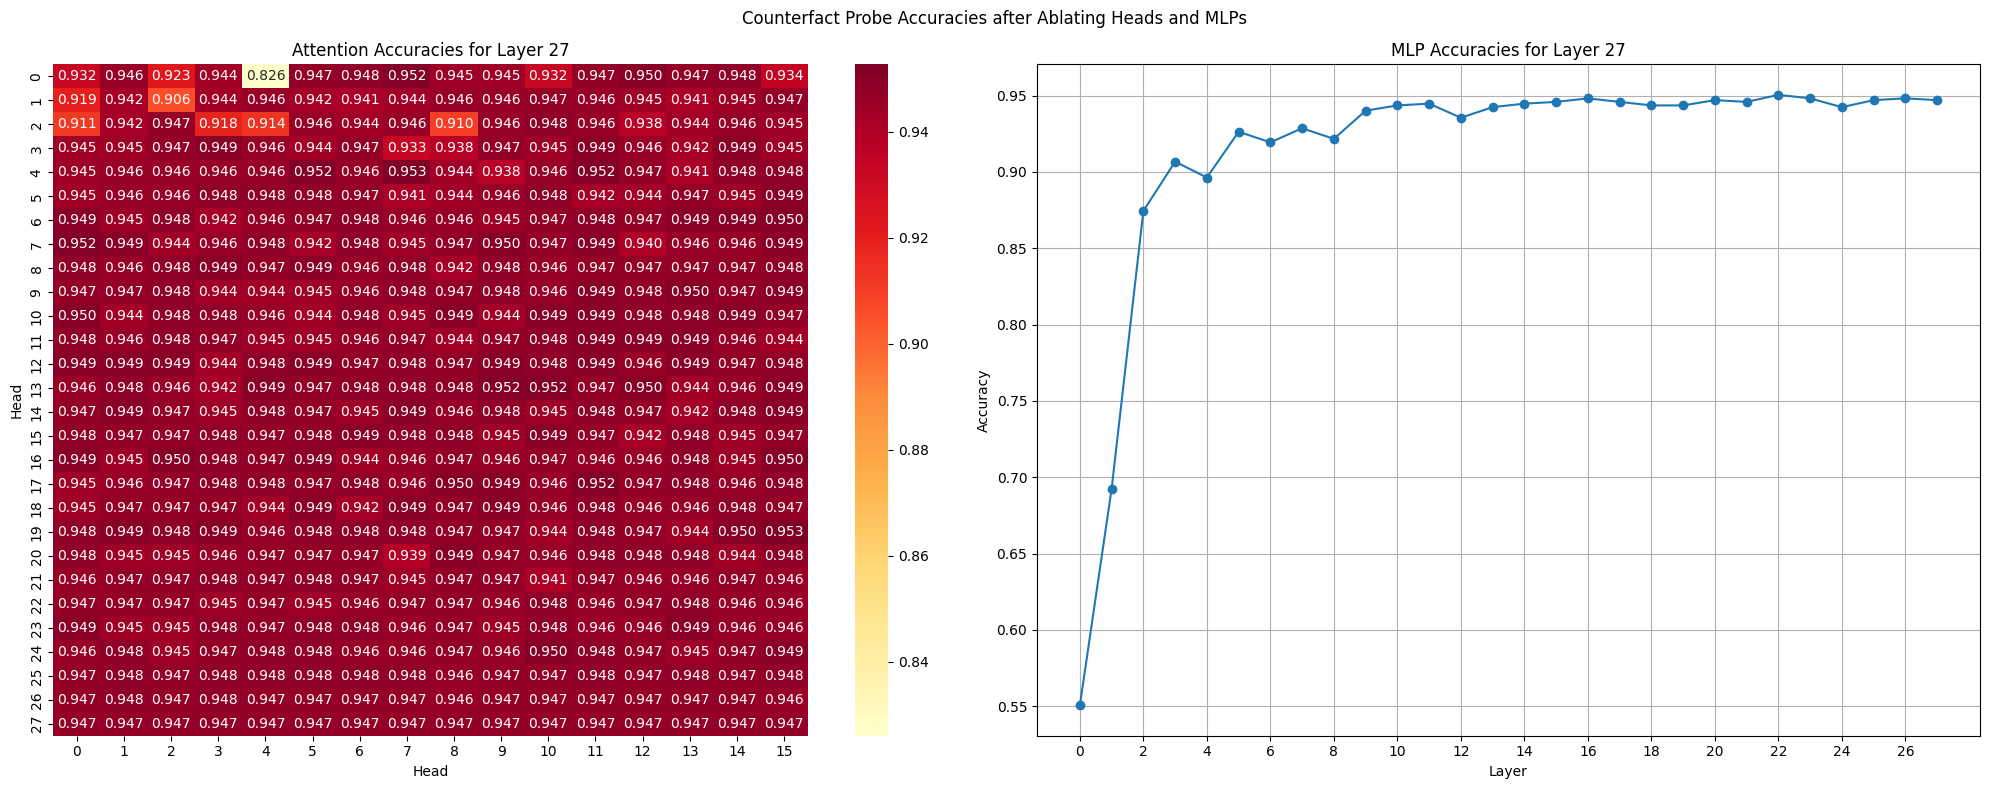

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming you've already loaded the data from the pickle file
# If not, uncomment and run these lines:
# with open(f"experiments/gemma_7b_manual/counterfact_ablation_results_{correct_prob_threshold=}.pkl", "rb") as f:
#     data = pickle.load(f)
#     attn_accuracies = data["attn_accuracies"]
#     mlp_accuracies = data["mlp_accuracies"]

# Plot Attention accuracies for layer 27
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Attention heatmap
attn_layer_27 = np.array([[attn_accuracies[layer][head][27] for head in range(16)] for layer in range(model.cfg.n_layers)])
sns.heatmap(attn_layer_27, ax=ax1, cmap="YlOrRd", annot=True, fmt=".3f", cbar=True)
ax1.set_title("Attention Accuracies for Layer 27")
ax1.set_xlabel("Head")
ax1.set_ylabel("Head")

# MLP line graph
mlp_accuracies_layer_27 = [mlp_accuracies[layer][27] for layer in range(28)]
ax2.plot(range(28), mlp_accuracies_layer_27, marker='o')
ax2.set_title("MLP Accuracies for Layer 27")
ax2.set_xlabel("Layer")
ax2.set_ylabel("Accuracy")
ax2.set_xticks(range(0, 28, 2))
ax2.grid(True)
fig.suptitle("Counterfact Probe Accuracies after Ablating Heads and MLPs")

plt.tight_layout()
plt.show()

### Patch Clean into Corrupt

In [8]:
all_prompts = counterfact_df["prompt"].tolist()
subject_list = [x for x in counterfact_df["subject"]]
start_subject_pos, end_subject_pos = get_token_sequence_pos(all_prompts, subject_list)
subject_ranges = list(zip(start_subject_pos, end_subject_pos))
tokenized = tokenizer(all_prompts[:16], return_tensors="pt", padding=True)
for i in range(16):
    input_ids = tokenized.input_ids[i]
    print(tokenizer.decode(input_ids[subject_ranges[i][0]:subject_ranges[i][1]]))

  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:00<00:00, 210.02it/s]

 Danielle Darrieux
 Thomas Joannes Stieltjes
Apple A5
 The Icelandic Dream
 Monell Chemical Senses Center
 Jean Galland
Tapio Kantanen
Toyota Cresta
Windows Embedded CE 6.0
Nathuram Godse
Stefanos Stratigos
Hohenlohe-Langenburg
 Thoranai
Honda Insight
 Northeastern University
 Cees Nooteboom


In [10]:
# mean ablate subject (patch in residual stream of corrupt at subject token)
mean_subject_cache = {}
all_prompts = counterfact_df["prompt"].tolist()
# gather mean of subject resid at all layers
for layer in range(-1, model.cfg.n_layers):
    mean_subject_cache[layer] = torch.zeros((model.cfg.d_model)).to("cuda")

batch_size = 16
all_prompts = counterfact_df["prompt"].tolist()
with torch.set_grad_enabled(False):
    for i in tqdm(range(0, len(all_prompts), batch_size)):
        tokenized_prompts = tokenizer(all_prompts[i:i+batch_size], return_tensors="pt", padding=True, truncation=True)
        prompt_toks = tokenized_prompts.input_ids
        attn_mask = tokenized_prompts.attention_mask
        _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: ('hook_resid_post' in name or "blocks.0.hook_resid_pre" in name))
        for layer in range(model.cfg.n_layers):
            for j in range(len(prompt_toks)):
                if subject_ranges[j][1] == 0:
                    mean_subject_cache[layer] += cache[f"blocks.{layer}.hook_resid_post"][j, subject_ranges[j][0]:].mean(dim=0)
                else:
                    mean_subject_cache[layer] += cache[f"blocks.{layer}.hook_resid_post"][j, subject_ranges[j][0]:subject_ranges[j][1]].mean(dim=0)
        for j in range(len(prompt_toks)):
            
            if subject_ranges[j][1] == 0:
                mean_subject_cache[-1] += cache[f"blocks.0.hook_resid_pre"][j, subject_ranges[j][0]:].mean(dim=0)
            else:
                mean_subject_cache[-1] += cache[f"blocks.0.hook_resid_pre"][j, subject_ranges[j][0]:subject_ranges[j][1]].mean(dim=0)
for layer in range(-1, model.cfg.n_layers):
    mean_subject_cache[layer] = mean_subject_cache[layer] / len(all_prompts)

# run probes

  0%|          | 0/136 [00:00<?, ?it/s]

100%|██████████| 136/136 [00:09<00:00, 14.48it/s]


In [19]:
# patch resid stream after 1, then patch things back
all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]
start_subject_pos, end_subject_pos = get_token_sequence_pos(all_prompts, subject_list)
subject_ranges = list(zip(start_subject_pos, end_subject_pos))

default_labels = np.concatenate([np.ones(len(counterfact_df["target_true"])), np.zeros(len(counterfact_df["target_false"]))], axis=0)
def evaluate_cache(caches, test_indices=test_indices, labels=default_labels, preprocess=True, probes=clfs, scalers=scalers):
    correct_responses = {}
    accuracies = {}
    for layer in range(model.cfg.n_layers):
        X_test = caches[layer][test_indices]
        if preprocess:
            X_test = scalers[layer].transform(X_test)
        y_test = labels[test_indices]

        clf = probes[layer]
        accuracies[layer] = clf.score(X_test, y_test)
        # get list of 0s and 1s for each element in test, 0 if probe is wrong and 1 if probe is right
        probe_results = clf.predict(X_test)
        correct_responses[layer] = (probe_results == y_test).astype(int)
    return correct_responses, accuracies


  0%|          | 0/68 [00:00<?, ?it/s]

100%|██████████| 68/68 [00:00<00:00, 118.37it/s]


In [25]:
def clean_unablate_subject(prompt_list, subject_list, layers, head=None, head_dict=None, attn=False, mlp=False, batch_size=32, first_ablated_layer=1):
    start_subject_pos, end_subject_pos = get_token_sequence_pos(prompt_list, subject_list)
    subject_ranges = list(zip(start_subject_pos, end_subject_pos))

    """
    Mean ablate subject of prompt for particular layer. Then, run probes and see which prompts the probes get wrong.
    prompt_list and subject_list should be same length
    """
    if isinstance(layers, int):
        layers = [layers]
    if isinstance(head, int):
        head = [head]

    if head is not None and head_dict is None:
        head_dict = {layer: head for layer in layers}

    caches = defaultdict(list)

    def patch_corrupt_hook(input, hook, layer, ablation_ranges):
        for b in range(input.shape[0]):
            if ablation_ranges[b][1] == 0:
                input[b, ablation_ranges[b][0]:] = mean_subject_cache[layer]
            else:
                input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] = mean_subject_cache[layer]
        return input

    if attn:
        def cache_clean_hook(input, hook, layer, head, ablation_ranges, clean_cache):
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    clean_cache[layer][head].append(input[b, ablation_ranges[b][0]:, head])
                else:
                    clean_cache[layer][head].append(input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head])
            return input

        def patch_clean_hook(input, hook, layer, head, ablation_ranges, clean_cache):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            # input is batch seq heads d_head
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:, head] = clean_cache[layer][b, head]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head] = clean_cache[layer][head][b]
            return input
    elif mlp:
        def cache_clean_hook(input, hook, layer, ablation_ranges, clean_cache):
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    clean_cache[layer].append(input[b, ablation_ranges[b][0]:])
                else:
                    clean_cache[layer].append(input[b, ablation_ranges[b][0]:ablation_ranges[b][1]])
            return input
        def patch_clean_hook(input, hook, layer, ablation_ranges, clean_cache):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:] = clean_cache[layer][b]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] = clean_cache[layer][b]
            return input

    for i in tqdm(range(0, len(prompt_list), batch_size)):
        # run patch clean hook
        tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        prompt_toks = tokenized.input_ids
        attn_mask = tokenized.attention_mask

        clean_cache_hooks = []
        # first, get clean cache
        if attn:
            clean_cache = defaultdict(lambda: defaultdict(list))
            for layer, heads in head_dict.items():
                for head in heads:
                    clean_cache_hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: cache_clean_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))
        elif mlp:
            clean_cache = defaultdict(list)
            for layer in layers:
                clean_cache_hooks.append((f"blocks.{layer}.hook_mlp_out", lambda input, hook: cache_clean_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))

        # run clean cache hook
        with torch.set_grad_enabled(False):
            with model.hooks(clean_cache_hooks):
                model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())

        # clean_cache should be developed
        if first_ablated_layer > 0:
            hooks = [(f"blocks.{first_ablated_layer-1}.hook_resid_post", lambda input, hook: patch_corrupt_hook(input, hook, layer=first_ablated_layer-1, ablation_ranges=subject_ranges[i:i+batch_size]))]
        else:
            hooks = [(f"blocks.{0}.hook_resid_pre", lambda input, hook: patch_corrupt_hook(input, hook, layer=-1, ablation_ranges=subject_ranges[i:i+batch_size]))]

        if attn:
            for layer, heads in head_dict.items():
                for head in heads:
                    hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: patch_clean_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))
        elif mlp:
            for layer in layers:
                hooks.append((f"blocks.{layer}.hook_mlp_out", lambda input, hook: patch_clean_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))

        with torch.set_grad_enabled(False):
            with model.hooks(hooks):
                _, cache = model.run_with_cache(prompt_toks.cuda(), attention_mask=attn_mask.cuda(), names_filter=lambda name: 'resid_post' in name)

        for layer in range(model.cfg.n_layers):
            caches[layer].append(cache[f"blocks.{layer}.hook_resid_post"][:, -1, :])
    for layer in range(model.cfg.n_layers):
        caches[layer] = torch.cat(caches[layer], dim=0).cpu().float().numpy()
    # return caches
    return *evaluate_cache(caches, probes=clfs, scalers=scalers), caches

In [26]:
all_prompts = [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_true"]).tolist()] + [("Consider the truthfulness of the following statement.\n\n" + x + "\n\nIs this statement true: ") for x in (counterfact_df["prompt"] + counterfact_df["target_false"]).tolist()]
subject_list = [x for x in counterfact_df["subject"]] + [x for x in counterfact_df["subject"]]

correct_responses, accuracies, caches = clean_unablate_subject(all_prompts, subject_list, layers=11, mlp=True, first_ablated_layer=10)
print(accuracies)

NameError: name 'asdf' is not defined

In [33]:
attn_correct_responses = defaultdict(dict)
attn_accuracies = defaultdict(dict)
mlp_correct_responses = {}
mlp_accuracies = {}
first_ablated_layer = 4
for layer in tqdm(range(first_ablated_layer, model.cfg.n_layers)):
    print("Layer: ", layer)
    # for head in range(model.cfg.n_heads):
    #     correct_responses, accuracies, _ = clean_unablate_subject(all_prompts, subject_list, attn=True, layers=layer, head=head, first_ablated_layer=first_ablated_layer)
    #     attn_correct_responses[layer][head] = correct_responses
    #     attn_accuracies[layer][head] = accuracies
    correct_responses, accuracies, _ = clean_unablate_subject(all_prompts, subject_list, mlp=True, layers=layer, first_ablated_layer=first_ablated_layer)
    mlp_correct_responses[layer] = correct_responses
    mlp_accuracies[layer] = accuracies

    with open(f"experiments/gemma_7b_manual/counterfact_corrupt_restoration_ablation_results_{correct_prob_threshold=}.pkl", "wb") as f:
        pickle.dump({"attn_correct_responses": attn_correct_responses, "attn_accuracies": attn_accuracies, "mlp_correct_responses": mlp_correct_responses, "mlp_accuracies": mlp_accuracies}, f)

  0%|          | 0/24 [00:00<?, ?it/s]

Layer:  4


  4%|▍         | 1/24 [00:42<16:15, 42.40s/it]

Layer:  5


  8%|▊         | 2/24 [01:25<15:39, 42.69s/it]

Layer:  6


 12%|█▎        | 3/24 [02:07<14:56, 42.67s/it]

Layer:  7


 17%|█▋        | 4/24 [02:50<14:15, 42.80s/it]

Layer:  8


 21%|██        | 5/24 [03:33<13:33, 42.83s/it]

Layer:  9


 25%|██▌       | 6/24 [04:16<12:51, 42.89s/it]

Layer:  10


 29%|██▉       | 7/24 [04:59<12:09, 42.89s/it]

Layer:  11


 33%|███▎      | 8/24 [05:42<11:26, 42.93s/it]

Layer:  12


 38%|███▊      | 9/24 [06:25<10:42, 42.85s/it]

Layer:  13


 42%|████▏     | 10/24 [07:08<10:00, 42.87s/it]

Layer:  14


 46%|████▌     | 11/24 [07:51<09:16, 42.84s/it]

Layer:  15


 50%|█████     | 12/24 [08:34<08:36, 43.05s/it]

Layer:  16


 54%|█████▍    | 13/24 [09:17<07:52, 42.97s/it]

Layer:  17


 58%|█████▊    | 14/24 [10:00<07:09, 42.98s/it]

Layer:  18


 62%|██████▎   | 15/24 [10:43<06:26, 42.99s/it]

Layer:  19


 67%|██████▋   | 16/24 [11:26<05:43, 42.99s/it]

Layer:  20


 71%|███████   | 17/24 [12:09<05:00, 42.92s/it]

Layer:  21


 75%|███████▌  | 18/24 [12:52<04:17, 42.99s/it]

Layer:  22


 79%|███████▉  | 19/24 [13:34<03:34, 42.89s/it]

Layer:  23


 83%|████████▎ | 20/24 [14:18<02:52, 43.02s/it]

Layer:  24


 88%|████████▊ | 21/24 [15:01<02:08, 42.95s/it]

Layer:  25


 92%|█████████▏| 22/24 [15:44<01:25, 42.95s/it]

Layer:  26


 96%|█████████▌| 23/24 [16:26<00:42, 42.90s/it]

Layer:  27


100%|██████████| 24/24 [17:09<00:00, 42.91s/it]


In [34]:
mlp_accuracies

{4: {0: 0.521889400921659,
  1: 0.5633640552995391,
  2: 0.6624423963133641,
  3: 0.6497695852534562,
  4: 0.48502304147465436,
  5: 0.48502304147465436,
  6: 0.48502304147465436,
  7: 0.5023041474654378,
  8: 0.48502304147465436,
  9: 0.48502304147465436,
  10: 0.48502304147465436,
  11: 0.4827188940092166,
  12: 0.5149769585253456,
  13: 0.5149769585253456,
  14: 0.5149769585253456,
  15: 0.5149769585253456,
  16: 0.4965437788018433,
  17: 0.4769585253456221,
  18: 0.48502304147465436,
  19: 0.47465437788018433,
  20: 0.5172811059907834,
  21: 0.5230414746543779,
  22: 0.48502304147465436,
  23: 0.4838709677419355,
  24: 0.48963133640552997,
  25: 0.48502304147465436,
  26: 0.4838709677419355,
  27: 0.48502304147465436},
 5: {0: 0.521889400921659,
  1: 0.5633640552995391,
  2: 0.6624423963133641,
  3: 0.6497695852534562,
  4: 0.48502304147465436,
  5: 0.48502304147465436,
  6: 0.4988479262672811,
  7: 0.5264976958525346,
  8: 0.48502304147465436,
  9: 0.49078341013824883,
  10: 0.485

In [35]:
for unablate_layer, accuracies in mlp_accuracies.items():
    print(f"Unablated Layer {unablate_layer} Accuracy: {accuracies[27]}")
# OLD

Unablated Layer 4 Accuracy: 0.48502304147465436
Unablated Layer 5 Accuracy: 0.48502304147465436
Unablated Layer 6 Accuracy: 0.48502304147465436
Unablated Layer 7 Accuracy: 0.48502304147465436
Unablated Layer 8 Accuracy: 0.48502304147465436
Unablated Layer 9 Accuracy: 0.4838709677419355
Unablated Layer 10 Accuracy: 0.4838709677419355
Unablated Layer 11 Accuracy: 0.48502304147465436
Unablated Layer 12 Accuracy: 0.48502304147465436
Unablated Layer 13 Accuracy: 0.48502304147465436
Unablated Layer 14 Accuracy: 0.4838709677419355
Unablated Layer 15 Accuracy: 0.4838709677419355
Unablated Layer 16 Accuracy: 0.48502304147465436
Unablated Layer 17 Accuracy: 0.4861751152073733
Unablated Layer 18 Accuracy: 0.4861751152073733
Unablated Layer 19 Accuracy: 0.48502304147465436
Unablated Layer 20 Accuracy: 0.4838709677419355
Unablated Layer 21 Accuracy: 0.4838709677419355
Unablated Layer 22 Accuracy: 0.4838709677419355
Unablated Layer 23 Accuracy: 0.4838709677419355
Unablated Layer 24 Accuracy: 0.48502

### Causal Tracing

In [11]:
import einops
from tasks.facts.CounterFactTask import CounterFactTask
from transformers import AutoTokenizer

right_tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="right")
forget_facts = 16
forget_kwargs = {"forget_fact_subset": forget_facts, "is_forget_dataset": True, "train_test_split": False}
maintain_kwargs = {"forget_fact_subset": forget_facts, "is_forget_dataset": False, "train_test_split": True}
forget_fact_eval = CounterFactTask(batch_size=32, tokenizer=right_tokenizer, device=device, criterion="cross_entropy", **forget_kwargs)
maintain_facts_eval = CounterFactTask(batch_size=32, tokenizer=right_tokenizer, device=device, criterion="cross_entropy", **maintain_kwargs)

Forget dataset with  16  examples
Maintain dataset with  2153  examples


In [24]:
# what is var of embeddings?
sample_tokenized = tokenizer(maintain_facts_eval.train_df["prompt"].tolist()[:32], return_tensors="pt", padding=True)
with torch.set_grad_enabled(False):
    _, cache = model.run_with_cache(sample_tokenized.input_ids.cuda(), attention_mask=sample_tokenized.attention_mask.cuda(), names_filter=lambda name: "embed" in name)
# print(cache["hook_embed"].shape)
print(cache['hook_embed'].shape)
empirical_std = cache['hook_embed'].std(dim=-1).mean().item()
print(empirical_std)

torch.Size([32, 14, 3072])
5.34375


In [83]:
def causal_trace(prompt_list, subject_list, layers, head=None, head_dict=None, attn=False, mlp=False, batch_size=32, corrupt_var=1, return_clean_and_corrupt_outputs=True):
    start_subject_pos, end_subject_pos = get_token_sequence_pos(prompt_list, subject_list)
    subject_ranges = list(zip(start_subject_pos, end_subject_pos))

    """
    Mean ablate subject of prompt for particular layer. Then, run probes and see which prompts the probes get wrong.
    prompt_list and subject_list should be same length
    """
    if isinstance(layers, int):
        layers = [layers]
    if isinstance(head, int):
        head = [head]

    if head is not None and head_dict is None:
        head_dict = {layer: head for layer in layers}

    caches = defaultdict(list)
    def corrupt_subject_hook(input, hook, ablation_ranges):
        for b in range(input.shape[0]):
            if ablation_ranges[b][1] == 0:
                input[b, ablation_ranges[b][0]:] += torch.randn_like(input[b, ablation_ranges[b][0]:]) * np.sqrt(corrupt_var)
            else:
                input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] += torch.randn_like(input[b, ablation_ranges[b][0]:ablation_ranges[b][1]]) * np.sqrt(corrupt_var)
        return input

    if attn:
        def cache_clean_hook(input, hook, layer, head, ablation_ranges, clean_cache):
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    clean_cache[layer][head].append(input[b, ablation_ranges[b][0]:, head])
                else:
                    clean_cache[layer][head].append(input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head])
            return input

        def patch_clean_hook(input, hook, layer, head, ablation_ranges, clean_cache):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            # input is batch seq heads d_head
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:, head] = clean_cache[layer][b, head]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1], head] = clean_cache[layer][head][b]
            return input
    elif mlp:
        def cache_clean_hook(input, hook, layer, ablation_ranges, clean_cache):
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    clean_cache[layer].append(input[b, ablation_ranges[b][0]:])
                else:
                    clean_cache[layer].append(input[b, ablation_ranges[b][0]:ablation_ranges[b][1]])
            return input
        def patch_clean_hook(input, hook, layer, ablation_ranges, clean_cache):
            """
            ablation_ranges is a list of tuples of the form (start, end) (inclusive of start, noninclusive of end) for each sequence in the batch
            """
            for b in range(input.shape[0]):
                if ablation_ranges[b][1] == 0:
                    input[b, ablation_ranges[b][0]:] = clean_cache[layer][b]
                else:
                    input[b, ablation_ranges[b][0]:ablation_ranges[b][1]] = clean_cache[layer][b]
            return input
    
    outputs = []
    clean_outputs = []
    corrupt_outputs = []
    for i in tqdm(range(0, len(prompt_list), batch_size)):
        # run patch clean hook
        tokenized = tokenizer(prompt_list[i:i+batch_size], return_tensors="pt", padding=True)
        prompt_toks = tokenized.input_ids
        attn_mask = tokenized.attention_mask

        clean_cache_hooks = []
        # first, get clean cache
        if attn:
            clean_cache = defaultdict(lambda: defaultdict(list))
            for layer, heads in head_dict.items():
                for head in heads:
                    clean_cache_hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: cache_clean_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))
        elif mlp:
            clean_cache = defaultdict(list)
            for layer in layers:
                clean_cache_hooks.append((f"blocks.{layer}.hook_mlp_out", lambda input, hook: cache_clean_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))

        # run clean cache hook
        with torch.set_grad_enabled(False):
            with model.hooks(clean_cache_hooks):
                clean_output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())[:, -1]
                if return_clean_and_corrupt_outputs:
                    clean_outputs.append(clean_output)

        hooks = [(f"blocks.0.hook_resid_pre", lambda input, hook: corrupt_subject_hook(input, hook, ablation_ranges=subject_ranges[i:i+batch_size]))]

        if return_clean_and_corrupt_outputs:
            with torch.set_grad_enabled(False):
                with model.hooks(hooks):
                    corrupt_output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())[:, -1]
                    corrupt_outputs.append(corrupt_output)

        if attn:
            for layer, heads in head_dict.items():
                for head in heads:
                    hooks.append((f"blocks.{layer}.attn.hook_z", lambda input, hook: patch_clean_hook(input, hook, layer=layer, head=head, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))
        elif mlp:
            for layer in layers:
                hooks.append((f"blocks.{layer}.hook_mlp_out", lambda input, hook: patch_clean_hook(input, hook, layer=layer, ablation_ranges=subject_ranges[i:i+batch_size], clean_cache=clean_cache)))

        with torch.set_grad_enabled(False):
            with model.hooks(hooks):
                output = model(prompt_toks.cuda(), attention_mask=attn_mask.cuda())[:, -1]
                outputs.append(output)
    if return_clean_and_corrupt_outputs:
        return torch.cat(outputs, dim=0), torch.cat(clean_outputs, dim=0), torch.cat(corrupt_outputs, dim=0)
    return torch.cat(outputs, dim=0)
outputs, clean_outputs, corrupt_outputs = causal_trace(forget_fact_eval.train_df["prompt"].tolist(), forget_fact_eval.train_df["subject"].tolist(), layers=11, mlp=True, corrupt_var=empirical_std)
print(outputs.shape)
print(clean_outputs.shape)
print(corrupt_outputs.shape)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

torch.Size([16, 256000])
torch.Size([16, 256000])
torch.Size([16, 256000])


In [91]:
all_attention_probs = []
all_attention_clean_probs = []
all_attention_corrupt_probs = []
all_mlp_probs = []
all_mlp_clean_probs = []
all_mlp_corrupt_probs = []

corrupt_var = empirical_std*3
# corrupt_var = empirical_std / 3

# facts_df = forget_fact_eval.train_df
facts_df = maintain_facts_eval.train_df

for layer in tqdm(range(model.cfg.n_layers)):
    print("Layer: ", layer, "doing mlp")
    mlp_outputs, mlp_clean_outputs, mlp_corrupt_outputs = causal_trace(facts_df["prompt"].tolist(), facts_df["subject"].tolist(), layers=layer, mlp=True, corrupt_var=corrupt_var)
    mlp_probs = torch.nn.functional.softmax(mlp_outputs, dim=1)
    all_mlp_probs.append(mlp_probs[torch.arange(mlp_probs.shape[0]), facts_df["first_token"].tolist()])
    mlp_clean_probs = torch.nn.functional.softmax(mlp_clean_outputs, dim=1)
    mlp_corrupt_probs = torch.nn.functional.softmax(mlp_corrupt_outputs, dim=1)
    all_mlp_clean_probs.append(mlp_clean_probs[torch.arange(mlp_clean_probs.shape[0]), facts_df["first_token"].tolist()])
    all_mlp_corrupt_probs.append(mlp_corrupt_probs[torch.arange(mlp_corrupt_probs.shape[0]), facts_df["first_token"].tolist()])

    print("Layer: ", layer, "doing attn")
    attention_outputs, attention_clean_outputs, attention_corrupt_outputs = causal_trace(facts_df["prompt"].tolist(), facts_df["subject"].tolist(), layers=layer, head=list(range(model.cfg.n_heads)), attn=True, corrupt_var=corrupt_var)
    attention_probs = torch.nn.functional.softmax(attention_outputs, dim=1)
    all_attention_probs.append(attention_probs[torch.arange(attention_probs.shape[0]), facts_df["first_token"].tolist()])
    attention_clean_probs = torch.nn.functional.softmax(attention_clean_outputs, dim=1)
    attention_corrupt_probs = torch.nn.functional.softmax(attention_corrupt_outputs, dim=1)
    all_attention_clean_probs.append(attention_clean_probs[torch.arange(attention_clean_probs.shape[0]), facts_df["first_token"].tolist()])
    all_attention_corrupt_probs.append(attention_corrupt_probs[torch.arange(attention_corrupt_probs.shape[0]), facts_df["first_token"].tolist()])
    
all_attention_probs = torch.stack(all_attention_probs, dim=0).float()
all_mlp_probs = torch.stack(all_mlp_probs, dim=0).float()
all_attention_clean_probs = torch.stack(all_attention_clean_probs, dim=0).float()
all_attention_corrupt_probs = torch.stack(all_attention_corrupt_probs, dim=0).float()
all_mlp_clean_probs = torch.stack(all_mlp_clean_probs, dim=0).float()
all_mlp_corrupt_probs = torch.stack(all_mlp_corrupt_probs, dim=0).float()

indirect_attention_effect = all_attention_probs - all_attention_corrupt_probs
indirect_mlp_effect = all_mlp_probs - all_mlp_corrupt_probs

print(all_attention_probs.shape)
print(all_mlp_probs.shape)

# OLD

  0%|          | 0/28 [00:00<?, ?it/s]

Layer:  0 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  0 doing attn


  4%|▎         | 1/28 [00:25<11:32, 25.67s/it]

Layer:  1 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


Layer:  1 doing attn


  7%|▋         | 2/28 [00:51<11:06, 25.62s/it]

Layer:  2 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


Layer:  2 doing attn


 11%|█         | 3/28 [01:17<10:43, 25.72s/it]

Layer:  3 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


Layer:  3 doing attn


 14%|█▍        | 4/28 [01:42<10:14, 25.62s/it]

Layer:  4 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


Layer:  4 doing attn


 18%|█▊        | 5/28 [02:07<09:47, 25.54s/it]

Layer:  5 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.34it/s]


Layer:  5 doing attn


 21%|██▏       | 6/28 [02:33<09:20, 25.48s/it]

Layer:  6 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  6 doing attn


 25%|██▌       | 7/28 [02:58<08:54, 25.44s/it]

Layer:  7 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  7 doing attn


 29%|██▊       | 8/28 [03:24<08:28, 25.41s/it]

Layer:  8 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  8 doing attn


 32%|███▏      | 9/28 [03:49<08:02, 25.39s/it]

Layer:  9 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  9 doing attn


 36%|███▌      | 10/28 [04:14<07:36, 25.38s/it]

Layer:  10 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  10 doing attn


 39%|███▉      | 11/28 [04:40<07:11, 25.36s/it]

Layer:  11 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  11 doing attn


 43%|████▎     | 12/28 [05:05<06:45, 25.35s/it]

Layer:  12 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  12 doing attn


 46%|████▋     | 13/28 [05:30<06:20, 25.34s/it]

Layer:  13 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  13 doing attn


 50%|█████     | 14/28 [05:56<05:54, 25.34s/it]

Layer:  14 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  14 doing attn


 54%|█████▎    | 15/28 [06:21<05:29, 25.34s/it]

Layer:  15 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  15 doing attn


 57%|█████▋    | 16/28 [06:46<05:04, 25.34s/it]

Layer:  16 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  16 doing attn


 61%|██████    | 17/28 [07:12<04:38, 25.34s/it]

Layer:  17 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  17 doing attn


 64%|██████▍   | 18/28 [07:37<04:13, 25.33s/it]

Layer:  18 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  18 doing attn


 68%|██████▊   | 19/28 [08:02<03:47, 25.33s/it]

Layer:  19 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  19 doing attn


 71%|███████▏  | 20/28 [08:28<03:23, 25.41s/it]

Layer:  20 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  20 doing attn


 75%|███████▌  | 21/28 [08:53<02:57, 25.38s/it]

Layer:  21 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  21 doing attn


 79%|███████▊  | 22/28 [09:18<02:32, 25.36s/it]

Layer:  22 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  22 doing attn


 82%|████████▏ | 23/28 [09:44<02:06, 25.35s/it]

Layer:  23 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  23 doing attn


 86%|████████▌ | 24/28 [10:09<01:41, 25.34s/it]

Layer:  24 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  24 doing attn


 89%|████████▉ | 25/28 [10:34<01:15, 25.33s/it]

Layer:  25 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  25 doing attn


 93%|█████████▎| 26/28 [11:00<00:50, 25.33s/it]

Layer:  26 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  26 doing attn


 96%|█████████▋| 27/28 [11:25<00:25, 25.33s/it]

Layer:  27 doing mlp


100%|██████████| 54/54 [00:12<00:00,  4.33it/s]


Layer:  27 doing attn


100%|██████████| 28/28 [11:50<00:00, 25.39s/it]

torch.Size([28, 1722])
torch.Size([28, 1722])


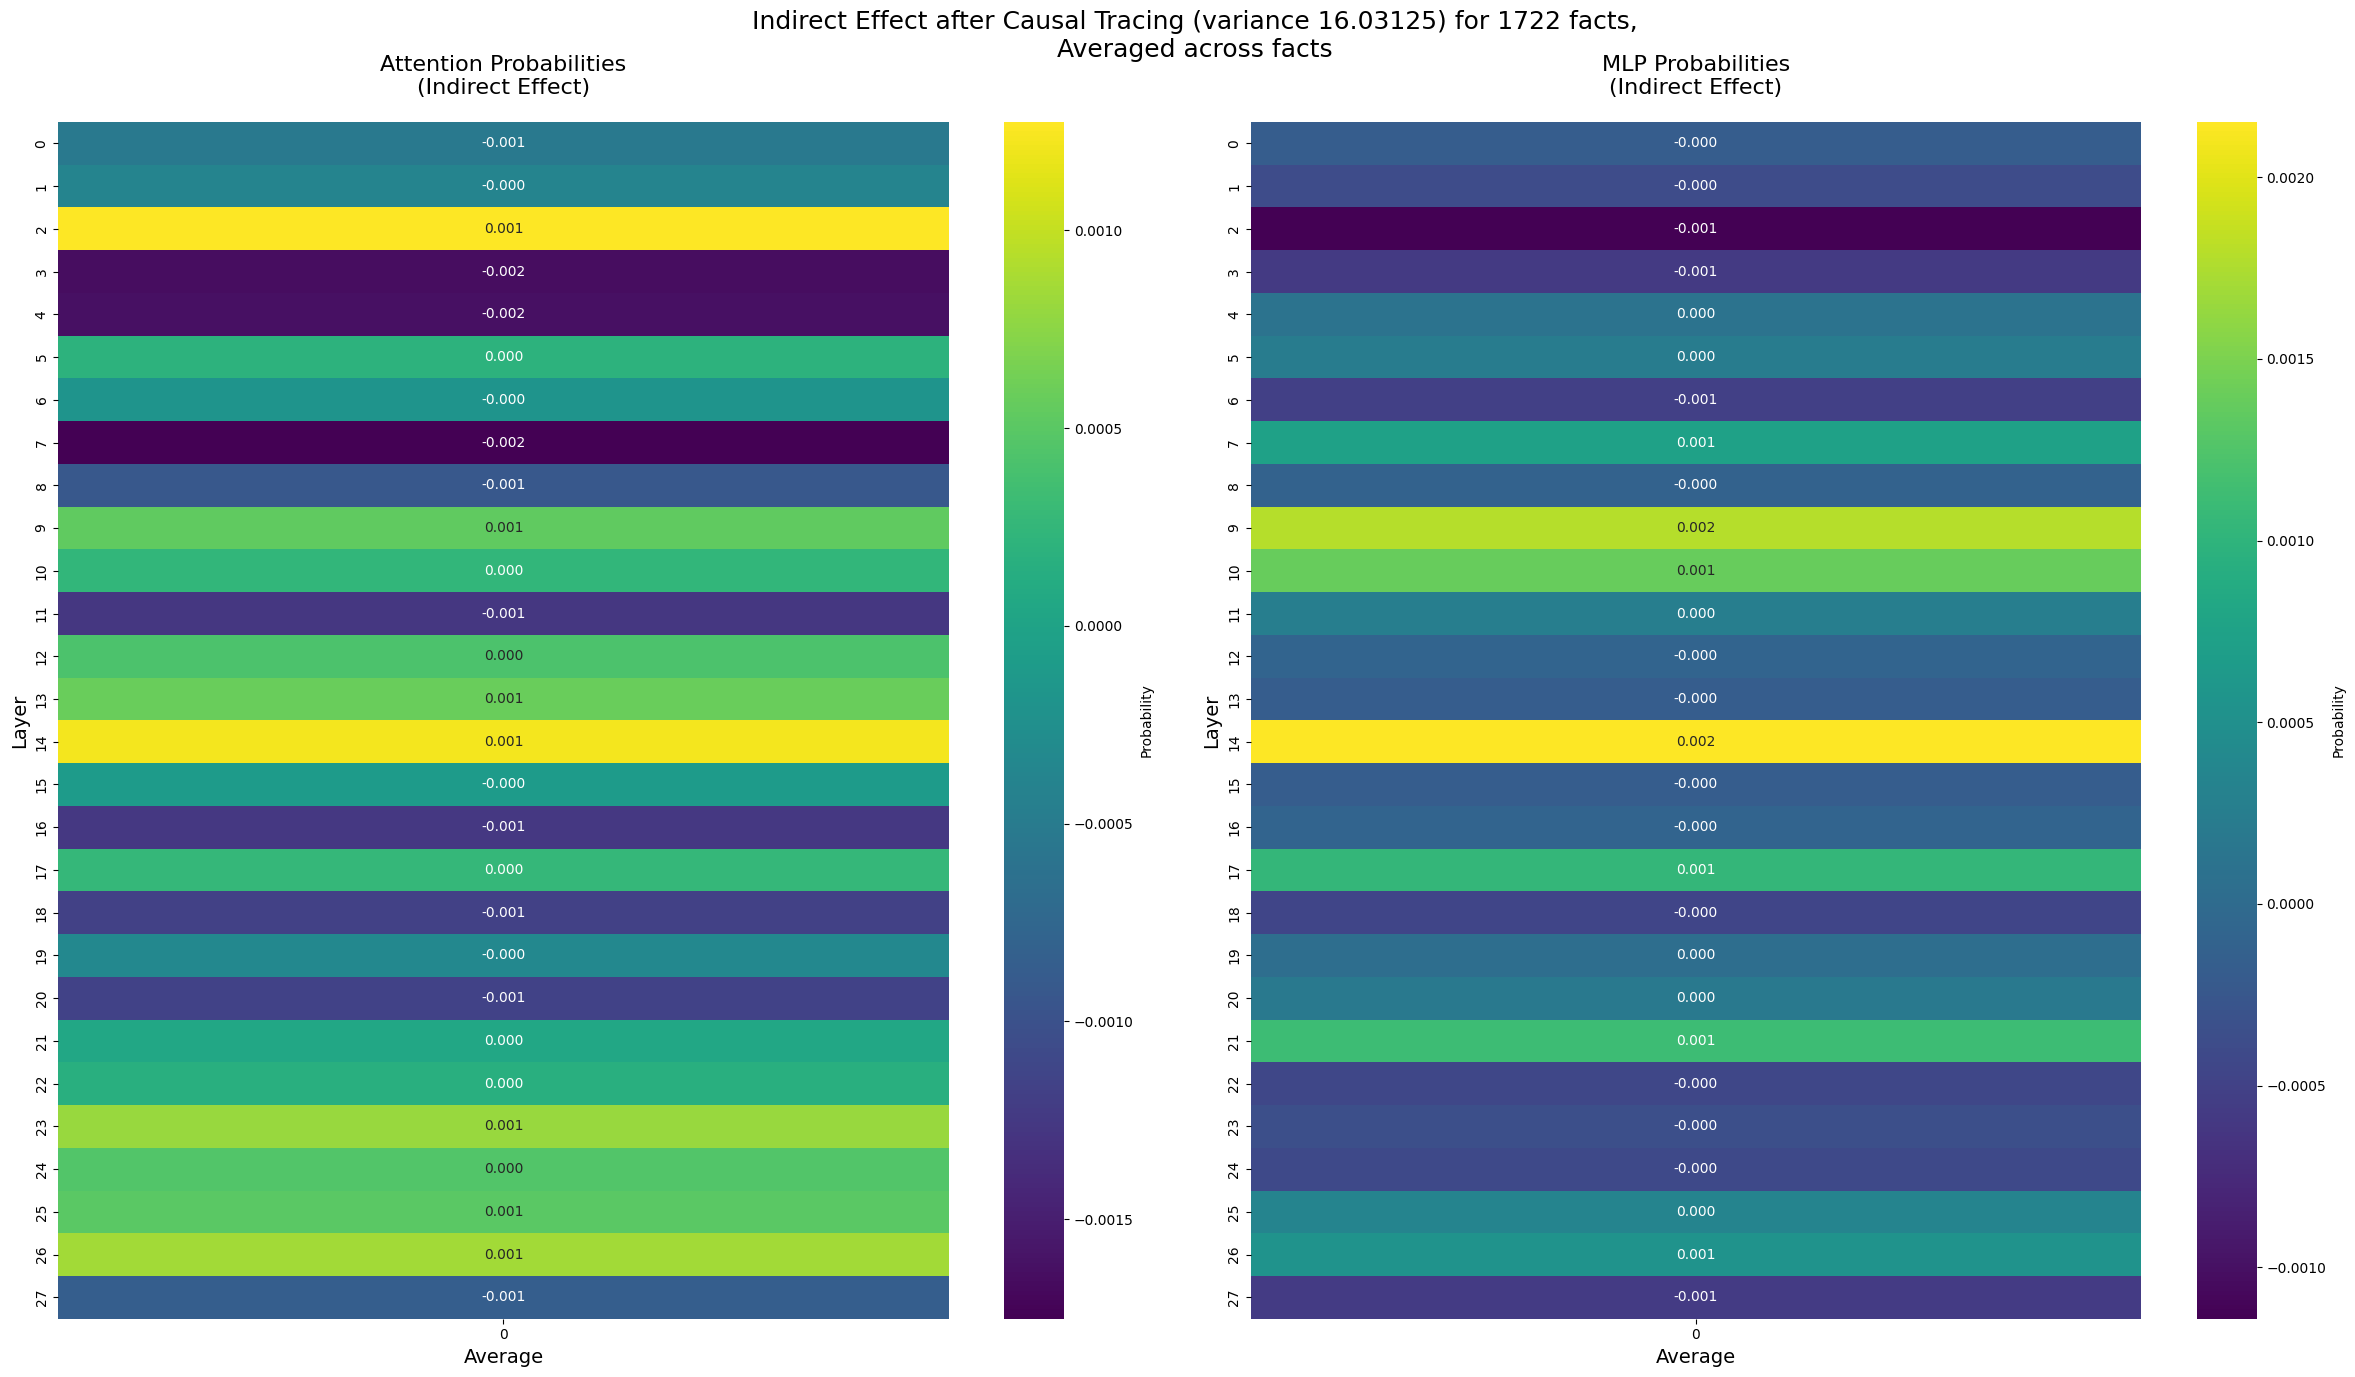

In [92]:
plot_facts_separately = False  # Set this to False to average over facts
normalize = False  # Set this to True to normalize before averaging, False to average raw values
plot_indirect_effect = True

def normalize_columns(data):
    return data / data.max(axis=0)

def process_data(data, plot_separately, normalize):
    if plot_separately:
        return data if not normalize else normalize_columns(data)
    else:
        if normalize:
            return normalize_columns(data).mean(axis=1, keepdims=True)
        else:
            return data.mean(axis=1, keepdims=True)

def plot_heatmap(ax, data, title, plot_separately):
    sns.heatmap(data, ax=ax, cmap="viridis", cbar_kws={'label': 'Probability'}, annot=True, fmt='.3f', 
                annot_kws={'size': 6 if plot_separately else 10})
    
    if plot_separately:
        max_values = data.max(axis=0)
        for j, max_val in enumerate(max_values):
            ax.text(j+0.5, -0.5, f'{max_val:.3f}', ha="center", va="center", 
                    color="black", fontsize=10, fontweight='bold')

    ax.set_xlabel("Fact Index" if plot_separately else "Average", fontsize=14)
    ax.set_ylabel("Layer", fontsize=14)
    return ax

# Process the data
if plot_indirect_effect:
    attn_data = process_data(indirect_attention_effect.cpu().numpy(), plot_facts_separately, normalize)
    mlp_data = process_data(indirect_mlp_effect.cpu().numpy(), plot_facts_separately, normalize)
else:
    attn_data = process_data(all_attention_probs.cpu().numpy(), plot_facts_separately, normalize)
    mlp_data = process_data(all_mlp_probs.cpu().numpy(), plot_facts_separately, normalize)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 14))  # Increased height to accommodate suptitle

# Attention heatmap
ax1 = plot_heatmap(ax1, attn_data, "Attention Probabilities" + ("(Indirect Effect)" if plot_indirect_effect else ""), plot_facts_separately)
ax1.set_title("Attention Probabilities\n" + ("(Indirect Effect)" if plot_indirect_effect else "") + ("(Normalized per Fact)" if normalize else ""), fontsize=16, pad=20)

# MLP heatmap
ax2 = plot_heatmap(ax2, mlp_data, "MLP Probabilities" + ("(Indirect Effect)" if plot_indirect_effect else ""), plot_facts_separately)
ax2.set_title("MLP Probabilities\n" + ("(Indirect Effect)" if plot_indirect_effect else "") + ("(Normalized per Fact)" if normalize else ""), fontsize=16, pad=20)

# Add suptitle
fig.suptitle(f"{'Indirect Effect' if plot_indirect_effect else 'Probabilities'} after Causal Tracing (variance {corrupt_var}) for {all_attention_probs.shape[1]} facts,\n" + 
             ("Normalized per Fact by maximum accuracy across layers" if normalize else "Averaged across facts"), 
             fontsize=18, y=0.98)  # Adjusted y position

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjusted top margin to make room for suptitle
plt.show()


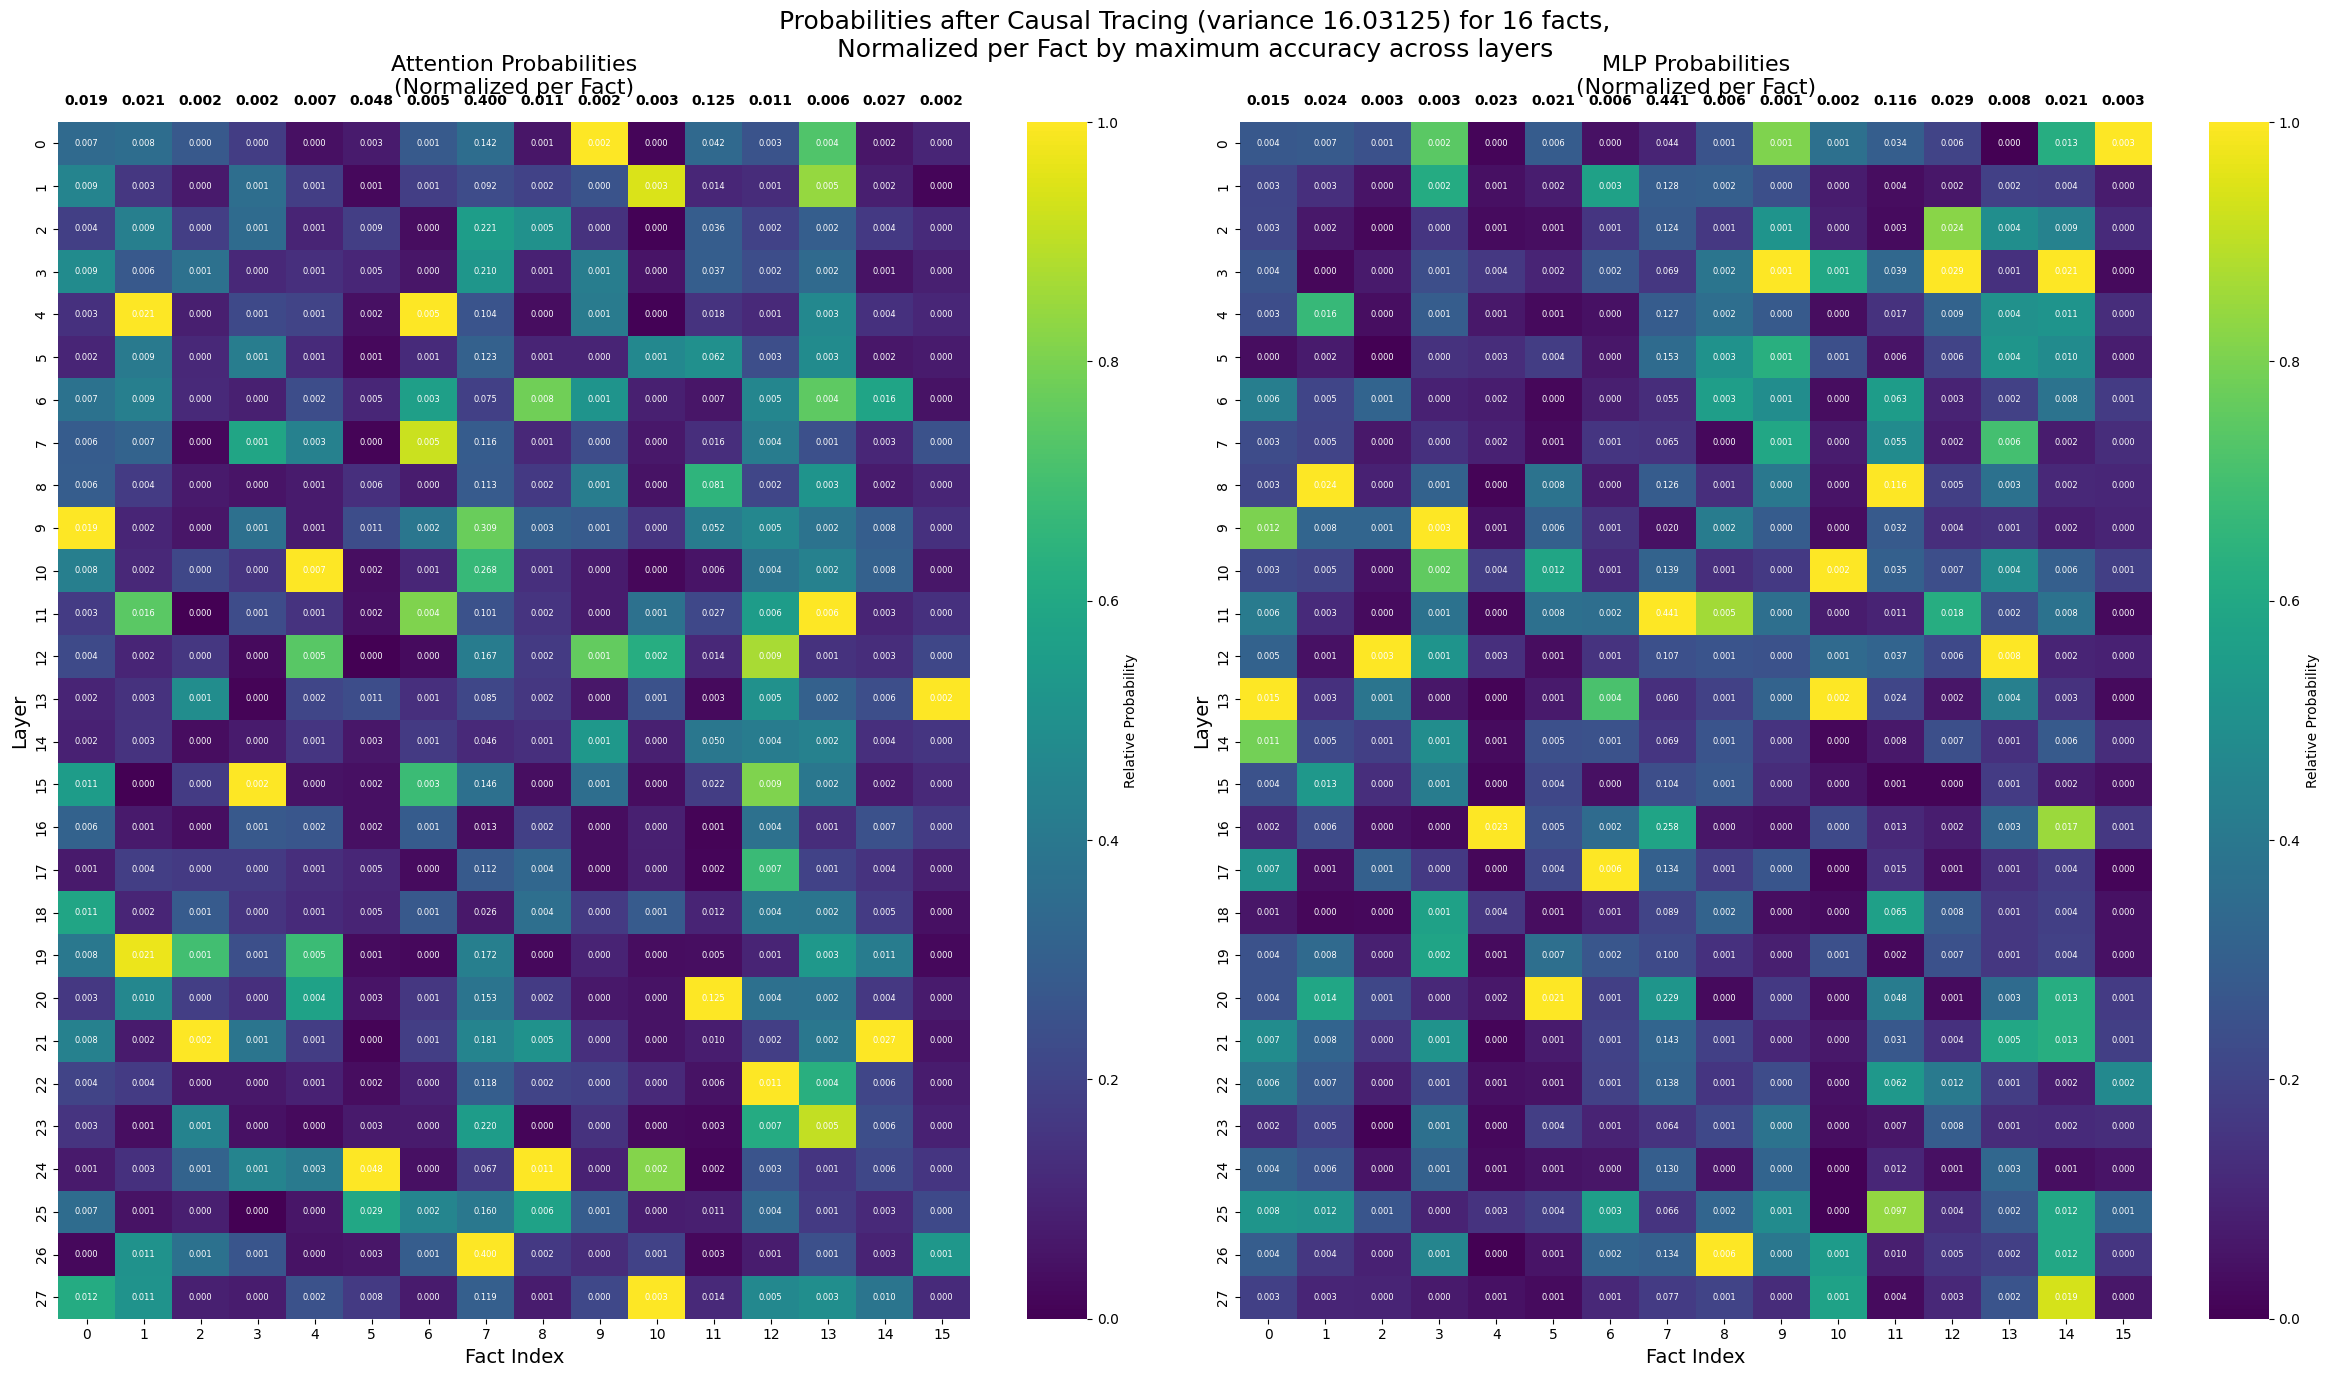

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming all_attention_probs and all_mlp_probs are already loaded and in the correct shape

plot_facts_separately = True
normalize = True

def normalize_columns(data):
    return data / data.max(axis=0)

def plot_heatmap(ax, data, title):
    normalized_data = normalize_columns(data)
    sns.heatmap(normalized_data, ax=ax, cmap="viridis", cbar_kws={'label': 'Relative Probability'}, annot=False)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j+0.5, i+0.5, f'{data[i,j]:.3f}', 
                    ha="center", va="center", color="w", fontsize=6)
    
    max_values = data.max(axis=0)
    for j, max_val in enumerate(max_values):
        ax.text(j+0.5, -0.5, f'{max_val:.3f}', ha="center", va="center", 
                color="black", fontsize=10, fontweight='bold')

    ax.set_xlabel("Fact Index", fontsize=14)
    ax.set_ylabel("Layer", fontsize=14)
    return ax

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 14))  # Increased height to accommodate suptitle

# Attention heatmap
ax1 = plot_heatmap(ax1, all_attention_probs.cpu().numpy(), "Attention Probabilities (Normalized per Fact)")
ax1.set_title("Attention Probabilities\n(Normalized per Fact)", fontsize=16, pad=20)

# MLP heatmap
ax2 = plot_heatmap(ax2, all_mlp_probs.cpu().numpy(), "MLP Probabilities (Normalized per Fact)")
ax2.set_title("MLP Probabilities\n(Normalized per Fact)", fontsize=16, pad=20)

# Add suptitle
fig.suptitle(f"Probabilities after Causal Tracing (variance {corrupt_var}) for {all_attention_probs.shape[1]} facts,\nNormalized per Fact by maximum accuracy across layers", 
             fontsize=18, y=0.98)  # Adjusted y position

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.90)  # Adjusted top margin to make room for suptitle
plt.show()

# Optionally, save the figure
# plt.savefig('counterfact_normalized_probabilities_heatmap_with_values.png', dpi=300, bbox_inches='tight')

# OLD

In [ ]:
# Need to 
# 1. Probe for correct sport with no changes
# 2. Probe for correct sport with just <bos>name
# 3. Probe after meal ablating attention heads after layer 2
# 4. Probe after meal ablating attention heads after layer 2 and just <bos>name

def train_test_probe(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
    clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
    # clf = LogisticRegression(random_state=0, max_iter=10000).fit(X_train, y_train)
    # results[layer] = clf.score(X_test, y_test)
    return clf.score(X_test, y_test)

def probe_last_layer(model, prompt_toks, targets, batch_size=None, layer=None):
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
            prompt_toks,
            names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
        )
        if layer is not None:
            cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
        else:
            cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            _, cache = model.run_with_cache(
                prompt_toks_batch,
                names_filter = lambda name: name == f"blocks.{model.cfg.n_layers-1}.hook_resid_post" if layer is None else f"blocks.{layer}.hook_resid_post"
            )
            if layer is not None:
                cache = cache[f"blocks.{layer}.hook_resid_post"][:, -1, :]
            else:
                cache = cache[f"blocks.{model.cfg.n_layers-1}.hook_resid_post"][:, -1, :]
            caches.append(cache)
        cache = torch.cat(caches, dim=0)
    print("last layer probe, cache shape: ", cache.shape)
    X = cache.cpu().float().numpy()
    print(X.shape, len(targets))
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # train logistic regression
    # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)

    # test_acc = clf.score(X_test, y_test)
    test_acc = train_test_probe(X, y)
    print(f"Accuracy: {test_acc}")

    return test_acc

def probe_across_layers(model, prompt_toks, targets, batch_size=None, cpu_multiprocessing=True):
    print(prompt_toks.shape)
    if batch_size is None:
        with torch.set_grad_enabled(False):
            _, cache = model.run_with_cache(
                prompt_toks,
                names_filter = lambda name: 'resid_post' in name
            )
            cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0) # layer batch d_model
    else:
        caches = []
        for i in range(0, prompt_toks.shape[0], batch_size):
            prompt_toks_batch = prompt_toks[i:i+batch_size]
            with torch.set_grad_enabled(False):
                _, cache = model.run_with_cache(
                    prompt_toks_batch,
                    names_filter = lambda name: 'resid_post' in name
                )
                # print(cache)
                # print(list(cache.values())[0].shape)
                cache = torch.stack([cache[key][:, -1, :] for key in cache.keys()], dim=0)
                # print(cache.shape)
            caches.append(cache)
        cache = torch.cat(caches, dim=1)
        # print("Batched Cache: ", cache.shape)
    print(f"Cache completed, {cache.shape}")
    results = []
    target_classes = []
    for target in targets:
        if target == "basketball":
            target_classes.append(0)
        elif target == "baseball":
            target_classes.append(1) 
        elif target == "football":
            target_classes.append(2)
    y = np.array(target_classes)

    X_data = {layer: cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1]) for layer in range(model.cfg.n_layers)}

    results = {}

    if cpu_multiprocessing:
        import multiprocess as mp
        import os
        from multiprocessing import Manager
        from multiprocessing import Pool
        os.environ["TOKENIZERS_PARALLELISM"] = "false"
        print("Trying cpu multiprocessing")
        from multiprocessing.dummy import Pool as ThreadPool

        start_time = time.time()
        with ThreadPool(processes=model.cfg.n_layers) as pool:  # Using ThreadPool
            results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(model.cfg.n_layers)])
        end_time = time.time()
        print(f"Time taken: {end_time - start_time} seconds")
        # with Pool(processes=2) as pool:
        #     results = pool.starmap(train_test_probe, [(X_data[layer], y) for layer in range(2)])
        print("finished multiprocessing")
        print(results)
        # Convert list of tuples to dictionary
        results_dict = {layer: results[i] for i, layer in enumerate(range(model.cfg.n_layers))}
        print(results_dict)

        # all_processes = {}
        # for layer in range(1):
        #     m = mp.Process(target=train_test_probe, args=(X_data[layer], y, results))
        #     all_processes[layer] = m
        #     m.start()
        # print(all_processes)
        # for layer in range(1):
        #     all_processes[layer].join()

    else:
        results = []
        start_time = time.time()
        for layer in tqdm(range(model.cfg.n_layers)):
            # print("converting cache")
            # X = cache[layer].cpu().float().numpy().reshape(-1, cache[layer].shape[-1])
            X = X_data[layer]
            # print("cache converted")

            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  
            
            # print("training probe")
            # # train logistic regression
            # clf = LogisticRegression(random_state=0, max_iter=500, solver='sag').fit(X_train, y_train)
            # print("testing probe")

            # test_acc = clf.score(X_test, y_test)
            # print(f"Layer {layer} Accuracy: {test_acc}")
            # results.append(test_acc)
            test_acc = train_test_probe(X, y)
            results.append(test_acc)
        print(f"Time taken: {time.time() - start_time} seconds")
    return results

def get_mean_cache(model, hook_name="attn_out"):
    pile = iter(load_dataset('monology/pile-uncopyrighted', split='train', streaming=True))
    text = [next(pile)['text'] for i in range(25)]
    toks = torch.stack(
        [
            torch.tensor(tokenizer.encode(t)[:78])
            for t in text
        ],
        dim=0
    )
    with torch.set_grad_enabled(False):
        _, mean_cache = model.run_with_cache(
            toks,
            names_filter = lambda name: any([h_name in name for h_name in [hook_name]])
        )
    return mean_cache


In [ ]:
m_cache = get_mean_cache(model)
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq d_model -> 1 1 d_model',
        'mean'
    )

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
mean_cache.keys()

dict_keys(['blocks.0.hook_attn_out', 'blocks.1.hook_attn_out', 'blocks.2.hook_attn_out', 'blocks.3.hook_attn_out', 'blocks.4.hook_attn_out', 'blocks.5.hook_attn_out', 'blocks.6.hook_attn_out', 'blocks.7.hook_attn_out', 'blocks.8.hook_attn_out', 'blocks.9.hook_attn_out', 'blocks.10.hook_attn_out', 'blocks.11.hook_attn_out', 'blocks.12.hook_attn_out', 'blocks.13.hook_attn_out', 'blocks.14.hook_attn_out', 'blocks.15.hook_attn_out', 'blocks.16.hook_attn_out', 'blocks.17.hook_attn_out', 'blocks.18.hook_attn_out', 'blocks.19.hook_attn_out', 'blocks.20.hook_attn_out', 'blocks.21.hook_attn_out', 'blocks.22.hook_attn_out', 'blocks.23.hook_attn_out', 'blocks.24.hook_attn_out', 'blocks.25.hook_attn_out', 'blocks.26.hook_attn_out', 'blocks.27.hook_attn_out', 'blocks.28.hook_attn_out', 'blocks.29.hook_attn_out', 'blocks.30.hook_attn_out', 'blocks.31.hook_attn_out', 'blocks.32.hook_attn_out', 'blocks.33.hook_attn_out', 'blocks.34.hook_attn_out', 'blocks.35.hook_attn_out', 'blocks.36.hook_attn_out', 

## Basic per-layer probes

In [ ]:
results = {}
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name

model.reset_hooks()
results['Prompt'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128, cpu_multiprocessing=True)

model.reset_hooks()
results['Athlete'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)

torch.Size([1566, 24])
Cache completed, torch.Size([42, 1566, 3584])
Trying cpu multiprocessing


KeyboardInterrupt: 

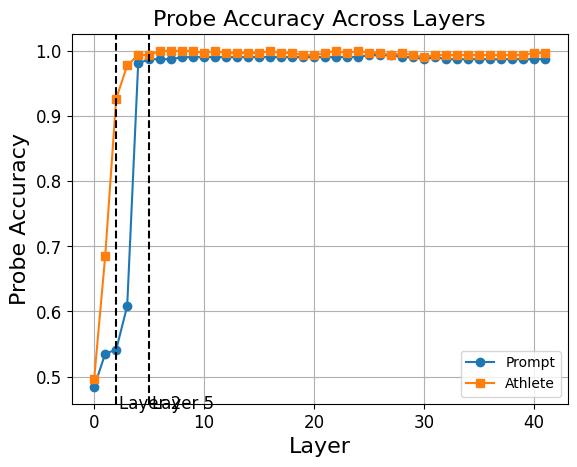

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

### Ablate layer heads

In [ ]:
# Add mean ablate hooks
ablate_first_layer = 5

def mean_ablate_hook(act, hook, mean_cache):
    if hook.layer() >= ablate_first_layer:
        print(f'Hooked {hook.name}')
        act = mean_cache[hook.name]
    return act

model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Prompt + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, full_prompt_toks, df['sport'].tolist(), batch_size=128)

# Add mean ablate hooks
model.add_hook(
    lambda name: 'attn_out' in name,
    functools.partial(mean_ablate_hook, mean_cache=mean_cache),
    "fwd"
)
results[f'Athlete + Ablate Heads at Layers >= {ablate_first_layer}'] = probe_across_layers(model, athl_prompt_toks, df['sport'].tolist(), batch_size=128)
model.reset_hooks()

torch.Size([1566, 24])
Hooked blocks.5.hook_attn_out
Hooked blocks.6.hook_attn_out
Hooked blocks.7.hook_attn_out
Hooked blocks.8.hook_attn_out
Hooked blocks.9.hook_attn_out
Hooked blocks.10.hook_attn_out
Hooked blocks.11.hook_attn_out
Hooked blocks.12.hook_attn_out
Hooked blocks.13.hook_attn_out
Hooked blocks.14.hook_attn_out
Hooked blocks.15.hook_attn_out
Hooked blocks.16.hook_attn_out
Hooked blocks.17.hook_attn_out
Hooked blocks.18.hook_attn_out
Hooked blocks.19.hook_attn_out
Hooked blocks.20.hook_attn_out
Hooked blocks.21.hook_attn_out
Hooked blocks.22.hook_attn_out
Hooked blocks.23.hook_attn_out
Hooked blocks.24.hook_attn_out
Hooked blocks.25.hook_attn_out
Hooked blocks.26.hook_attn_out
Hooked blocks.27.hook_attn_out
Hooked blocks.28.hook_attn_out
Hooked blocks.29.hook_attn_out
Hooked blocks.30.hook_attn_out
Hooked blocks.31.hook_attn_out
Hooked blocks.32.hook_attn_out
Hooked blocks.33.hook_attn_out
Hooked blocks.34.hook_attn_out
Hooked blocks.35.hook_attn_out
Hooked blocks.36.hook

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.711870431900024 seconds
finished multiprocessing
[0.4840764331210191, 0.535031847133758, 0.5414012738853503, 0.60828025477707, 0.9808917197452229, 0.9840764331210191, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9713375796178344, 0.964968152866242, 0.9490445859872612, 0.9426751592356688, 0.9299363057324841, 0.9267515923566879, 0.9331210191082803, 0.9140127388535032, 0.9076433121019108, 0.9044585987261147, 0.910828025477707, 0.8980891719745223, 0.8980891719745223, 0.8853503184713376, 0.8853503184713376, 0.8726114649681529, 0.8789808917197452, 0.8248407643312102, 0.7961783439490446, 0.8057324840764332, 0.7834394904458599, 0.7515923566878981, 0.732484076433121, 0.7133757961783439, 0.7070063694267515, 0.6815286624203821, 0.6847133757961783, 0.6719745222929936, 0.6751592356687898, 0.6719745222929936, 0.6656050955414012, 0.6687898089171974, 0.6719745222929936]
{0: 0.4840764331210191, 1: 0.535031847133758, 2: 0.5414012738853503, 3: 0.60828025477707, 4: 0.980891

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Time taken: 54.88229584693909 seconds
finished multiprocessing
[0.4968152866242038, 0.6847133757961783, 0.9267515923566879, 0.9777070063694268, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9936305732484076, 0.9872611464968153, 0.9904458598726115, 0.9904458598726115, 0.9840764331210191, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9904458598726115, 0.9936305732484076, 0.9936305732484076, 0.9936305732484076, 0.9904458598726115, 0.9872611464968153, 0.9840764331210191, 0.9840764331210191, 0.9808917197452229, 0.9777070063694268, 0.9777070063694268, 0.9777070063694268, 0.9585987261146497, 0.9554140127388535, 0.9363057324840764, 0.9394904458598726, 0.9299363057324841, 0.9267515923566879, 0.9299363057324841, 0.9299363057324841, 0.9299363057324841, 0.9235668789808917, 0.9203821656050956, 0.9203821656050956, 0.9203821656050956, 0.9140127388535032]
{0: 0.4968152866242038, 1: 0.6847133757961783, 2: 0.9267515923566879, 3: 0.9777070063694268, 4: 

/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


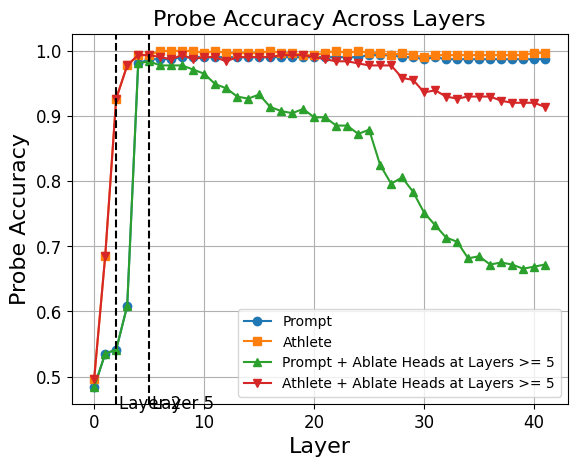

(50859081728, 85167243264)


In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
markers = ['o', 's', '^', 'v', '*', 'p', 'P', 'X', 'd']
for i, (k, v) in enumerate(results.items()):
    plt.plot(v, label=k, marker=markers[i])

# Add vertical dotted lines at x = 2, x = 7
plt.axvline(x=2, color='k', linestyle='--')
plt.axvline(x=5, color='k', linestyle='--')
# Label these vertical lines
plt.text(2.3, 0.45, 'Layer 2', fontsize=12)
plt.text(5.3, 0.45, 'Layer 5', fontsize=12)

plt.legend()
plt.xlabel('Layer', fontsize=16)
plt.ylabel('Probe Accuracy', fontsize=16)
plt.title('Probe Accuracy Across Layers', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()
print(torch.cuda.mem_get_info())

## Early attention heads

In [ ]:
full_prompt_toks = tokenize_instructions(tokenizer, df['prompt'].tolist()) # Full prompt
athl_prompt_toks = tokenize_instructions(tokenizer, df['athlete'].tolist()) # <bos>name
m_cache = get_mean_cache(model, hook_name="hook_z")
mean_cache = {}
for k in m_cache.keys():
    mean_cache[k] = einops.reduce(
        m_cache[k],
        'batch seq head d_model -> 1 1 head d_model',
        'mean'
    )
print(torch.cuda.mem_get_info())

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

(50863276032, 85167243264)


In [ ]:
ablate_first_layer = 5
def act_patch_hook_z(act, hook, patch_cache, patch_layer, patch_head):
    # heads_to_patch is [(layer, head)]
    # heads = [head for layer, head in heads_to_patch if layer == hook.layer()]

    # act is batch head seq d_model

    # want to patch head and every head after layer ablate_first_layer
    if hook.layer() == patch_layer:
        act[:, :, patch_head, :] = patch_cache[hook.name][:, :, patch_head, :]
    elif hook.layer() >= ablate_first_layer:
        act = patch_cache[hook.name]

    return act


layer_range = range(0, ablate_first_layer)
head_range = range(0, model.cfg.n_heads)

heads_to_patch = [
    (layer, head)
    for layer in layer_range
    for head in head_range
]

# Get patch cache
# results_mat = torch.zeros((len(list(layer_range)), len(list(head_range))), device=device)
# for (layer, head) in tqdm(heads_to_patch):
#     # print(f'Patching L{layer}H{head}')

#     model.reset_hooks()

#     model.add_hook(
#         lambda name: 'hook_z' in name,
#         functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=layer, patch_head=head),
#         "fwd"
#     )

#     results_mat[layer, head] += probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), batch_size=64, layer=ablate_first_layer) 

#     model.reset_hooks()
# torch.save(results_mat, f'results/9b_patch_results_{ablate_first_layer=}.pt')

results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')

/tmp/ipykernel_2267936/1760785832.py:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


In [ ]:
# Get baseline accuracy
model.reset_hooks()
model.add_hook(
    lambda name: 'hook_z' in name,
    functools.partial(act_patch_hook_z, patch_cache=mean_cache, patch_layer=-1, patch_head=-1),
    "fwd"
)

baseline_acc = probe_last_layer(model, full_prompt_toks, df['sport'].tolist(), layer=ablate_first_layer, batch_size=64) 

model.reset_hooks()

last layer probe, cache shape:  torch.Size([1566, 3584])
(1566, 3584) 1566
Accuracy: 0.9808917197452229


/data/phillip_guo/miniconda3/envs/unlrn/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


/tmp/ipykernel_2267936/2255518465.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


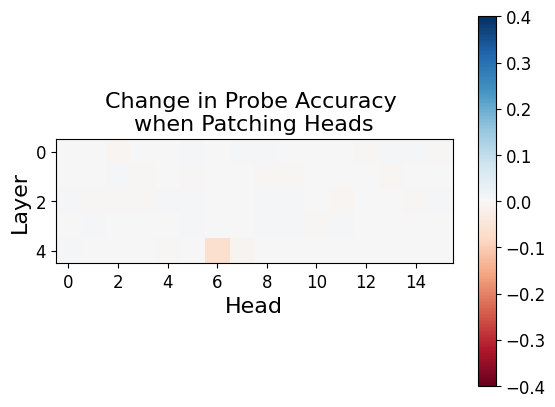

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy() - baseline_acc, cmap='RdBu', vmax=.4, vmin=-.4)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Change in Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')

/tmp/ipykernel_2267936/4258570237.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')


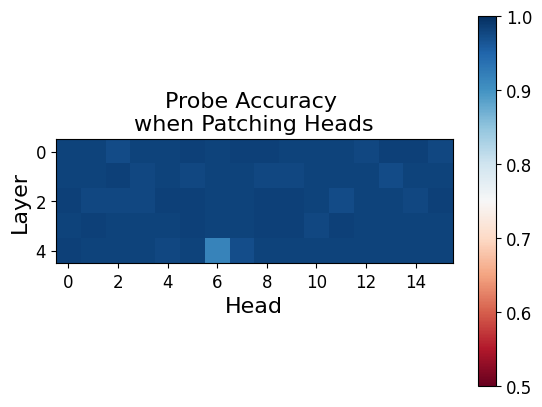

In [ ]:
results_mat = torch.load(f'results/9b_patch_results_{ablate_first_layer=}.pt')
import matplotlib.pyplot as plt

fig = plt.figure()
plt.imshow(results_mat.cpu().numpy(), cmap='RdBu', vmax=1, vmin=0.5)
plt.xlabel('Head', fontsize=16)
plt.ylabel('Layer', fontsize=16)
plt.title('Probe Accuracy \nwhen Patching Heads', fontsize=16)
# increase font size of ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# increase font size of colorbar
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
plt.show()
# fig.savefig(f'results/9b_patch_heatmap_{ablate_first_layer=}.pdf')